In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH =50

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss(reduction="none")(air_pr.float(), air_x.float())
        air_loss = torch.where(air_x == 1, air_loss, air_loss * 10.0)
        air_loss = air_loss.mean()
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss(reduction="none")(bone_pr.float(), bone_x.float())
        bone_loss = torch.where(bone_x == 1, bone_loss * 10.0, bone_loss)
        bone_loss = bone_loss.mean()
        
        _loss = _gen + air_loss + bone_loss + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [40]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        y_pr = y_pr * air_x
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [45]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [18]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [19]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [20]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [21]:
len(trainset), len(testset)

(1344, 191)

In [22]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f69e7ef4d90>,)

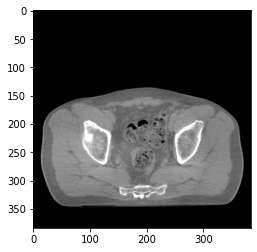

In [23]:
plt.imshow(x.squeeze(), 'gray'),

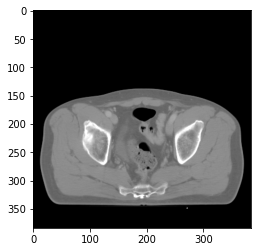

In [24]:
plt.imshow(y.squeeze(), 'gray')

In [25]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [26]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [28]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [29]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [30]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [31]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [05:06,  1.82s/it]
168it [01:18,  2.13it/s]
24it [00:11,  2.06it/s]
168it [04:58,  1.78s/it]
168it [01:15,  2.21it/s]
24it [00:11,  2.05it/s]
168it [05:02,  1.80s/it]
168it [01:16,  2.19it/s]
24it [00:11,  2.03it/s]
168it [04:58,  1.78s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.06it/s]
168it [05:02,  1.80s/it]
168it [01:15,  2.21it/s]
24it [00:11,  2.06it/s]
168it [05:07,  1.83s/it]
168it [01:17,  2.17it/s]
24it [00:12,  1.95it/s]
168it [05:01,  1.79s/it]
168it [01:18,  2.15it/s]
24it [00:11,  2.07it/s]
168it [04:59,  1.78s/it]
168it [01:12,  2.30it/s]
24it [00:11,  2.05it/s]
168it [05:02,  1.80s/it]
168it [01:15,  2.21it/s]
24it [00:11,  2.06it/s]
168it [05:00,  1.79s/it]
168it [01:15,  2.23it/s]
24it [00:11,  2.06it/s]
168it [05:00,  1.79s/it]
168it [01:16,  2.19it/s]
24it [00:11,  2.01it/s]
168it [05:07,  1.83s/it]
168it [01:18,  2.15it/s]
24it [00:11,  2.04it/s]
168it [04:58,  1.78s/it]
168it [01:16,  2.21it/s]
24it [00:11,  2.06it/s]
168it [05:02,  1.80s/it]
168it [01:16,

In [32]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [33]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [34]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9041787385940552
psnr score = 26.70733642578125
snr score = 16.770275115966797
mae error = 0.013916999101638794
air dice score = 0.9959015585899825
bone dice score = 0.9578107183586401


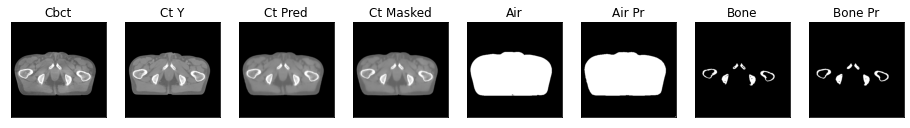

ssim score = 0.905759334564209
psnr score = 26.782865524291992
snr score = 16.893339157104492
mae error = 0.013914348557591438
air dice score = 0.9952328421716223
bone dice score = 0.9492906307072723


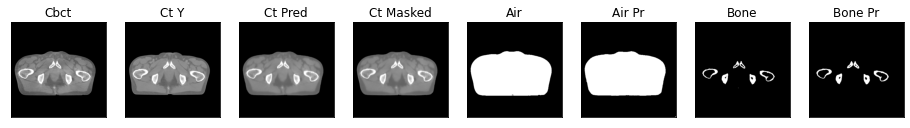

ssim score = 0.9049961566925049
psnr score = 26.714860916137695
snr score = 16.988231658935547
mae error = 0.014715558849275112
air dice score = 0.995774523033286
bone dice score = 0.9459843638954514


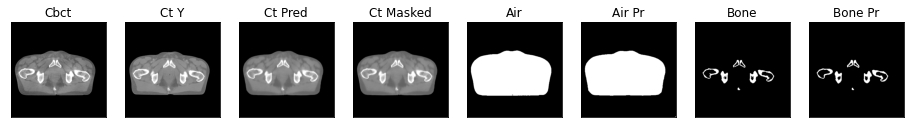

ssim score = 0.9025374054908752
psnr score = 26.731525421142578
snr score = 17.094146728515625
mae error = 0.014876733534038067
air dice score = 0.9961797774991894
bone dice score = 0.9372312983669687


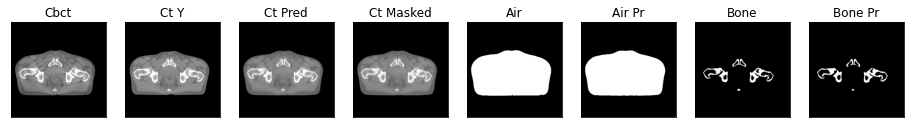

ssim score = 0.9019967913627625
psnr score = 26.84539794921875
snr score = 17.248321533203125
mae error = 0.014987647533416748
air dice score = 0.9959098786828463
bone dice score = 0.929194006464311


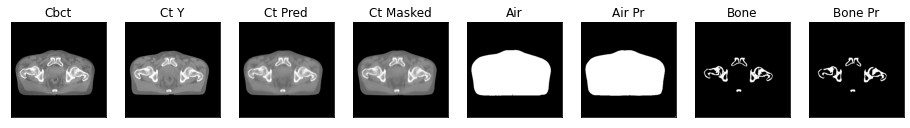

ssim score = 0.8994059562683105
psnr score = 26.932819366455078
snr score = 17.472278594970703
mae error = 0.015368337742984295
air dice score = 0.9957141433270251
bone dice score = 0.9272546088695628


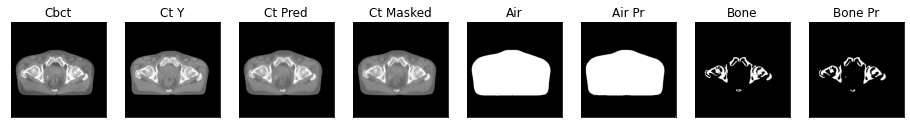

ssim score = 0.8996936082839966
psnr score = 27.10843849182129
snr score = 17.623838424682617
mae error = 0.015164663083851337
air dice score = 0.9944332440646402
bone dice score = 0.9391456526931895


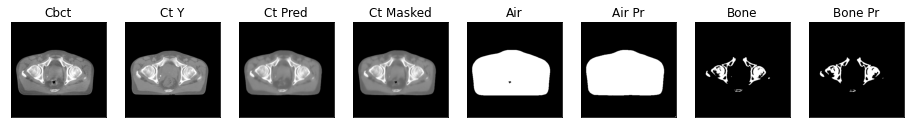

ssim score = 0.8988069295883179
psnr score = 27.306419372558594
snr score = 17.63628387451172
mae error = 0.014494193717837334
air dice score = 0.9957469966943524
bone dice score = 0.9456161757020601


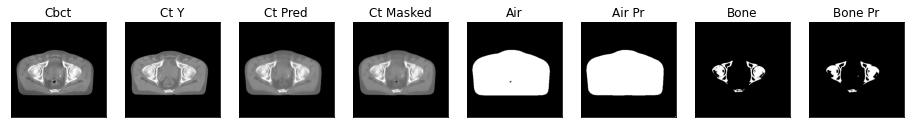

1it [00:23, 23.09s/it]

ssim score = 0.9031168818473816
psnr score = 27.63089370727539
snr score = 17.86620330810547
mae error = 0.01390544418245554
air dice score = 0.9956579961855337
bone dice score = 0.9568597705512766


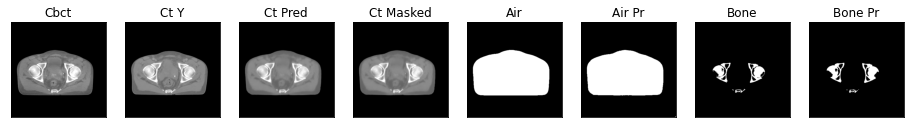

ssim score = 0.9070531129837036
psnr score = 27.828304290771484
snr score = 18.04833221435547
mae error = 0.013609912246465683
air dice score = 0.9946197588590269
bone dice score = 0.9493658440669613


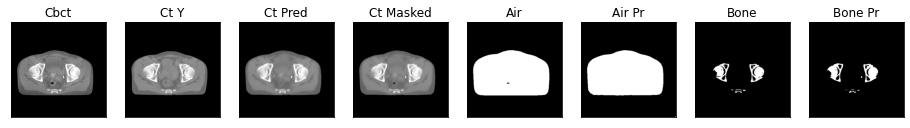

ssim score = 0.909685492515564
psnr score = 27.92761993408203
snr score = 18.179916381835938
mae error = 0.013599668629467487
air dice score = 0.9960518084768225
bone dice score = 0.9577672459193495


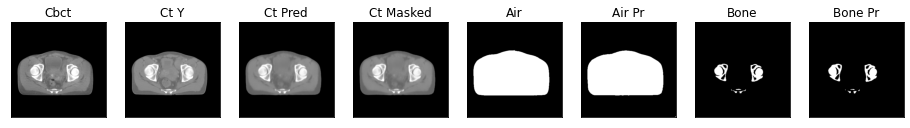

ssim score = 0.9101075530052185
psnr score = 27.794597625732422
snr score = 18.07060432434082
mae error = 0.013929796405136585
air dice score = 0.9928060532662663
bone dice score = 0.9636844891480817


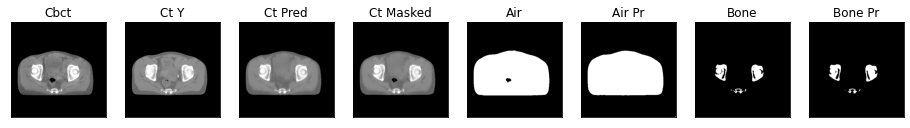

ssim score = 0.9166971445083618
psnr score = 27.9638671875
snr score = 18.20795249938965
mae error = 0.013838032260537148
air dice score = 0.9900717216323822
bone dice score = 0.968643490116239


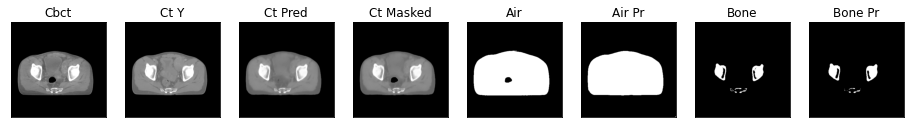

ssim score = 0.9128753542900085
psnr score = 27.723281860351562
snr score = 17.825408935546875
mae error = 0.014238627627491951
air dice score = 0.9892889459397011
bone dice score = 0.9460839247921046


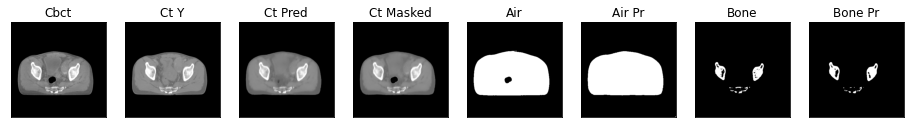

ssim score = 0.9122753143310547
psnr score = 27.581787109375
snr score = 17.598255157470703
mae error = 0.014356858097016811
air dice score = 0.9907299625388996
bone dice score = 0.927674203359412


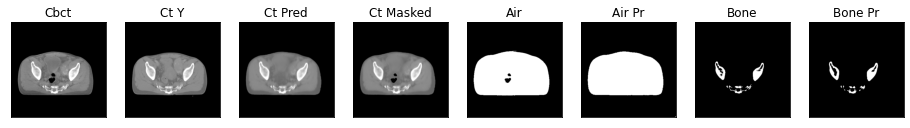

ssim score = 0.9057610630989075
psnr score = 26.797258377075195
snr score = 16.837207794189453
mae error = 0.015238693915307522
air dice score = 0.9913485027896104
bone dice score = 0.9335015772879054


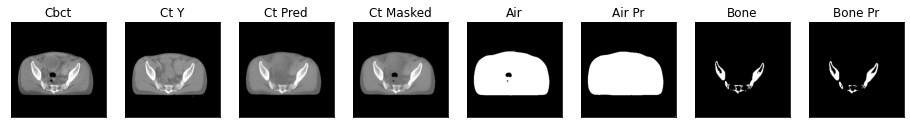

2it [00:25, 16.85s/it]

ssim score = 0.9036521315574646
psnr score = 26.307466506958008
snr score = 16.344873428344727
mae error = 0.0158806424587965
air dice score = 0.9881756938830631
bone dice score = 0.9439542093972816


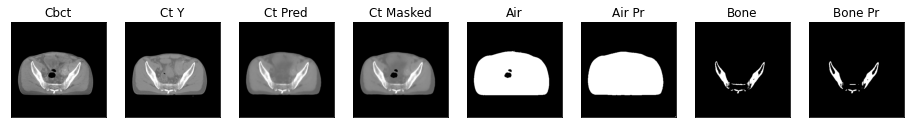

ssim score = 0.8992089629173279
psnr score = 25.99706268310547
snr score = 15.932708740234375
mae error = 0.016363292932510376
air dice score = 0.9844221817666658
bone dice score = 0.9212492345386253


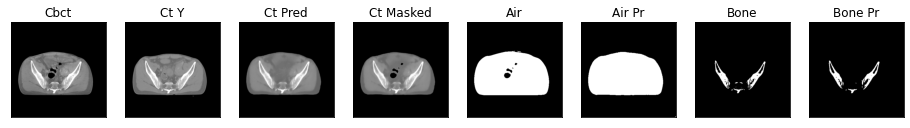

ssim score = 0.8971250653266907
psnr score = 25.589330673217773
snr score = 15.474296569824219
mae error = 0.016769113019108772
air dice score = 0.9852836119445797
bone dice score = 0.9164168365521475


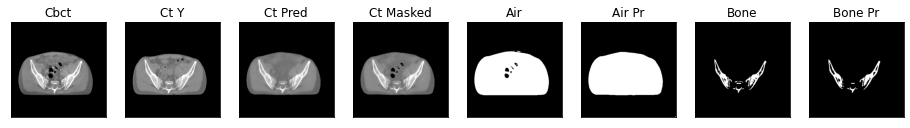

ssim score = 0.8955016136169434
psnr score = 24.928150177001953
snr score = 14.800806045532227
mae error = 0.017817001789808273
air dice score = 0.9864635647055061
bone dice score = 0.9182051595559578


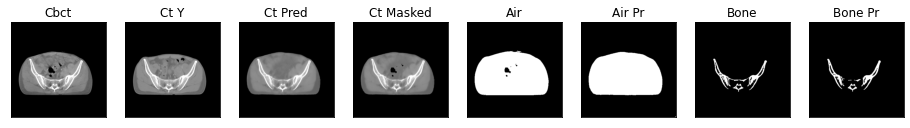

ssim score = 0.8916801810264587
psnr score = 24.60251235961914
snr score = 14.410322189331055
mae error = 0.018328798934817314
air dice score = 0.9880650104585094
bone dice score = 0.9022796960418307


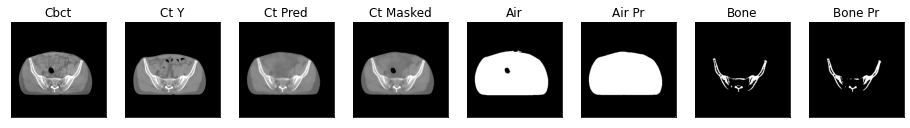

ssim score = 0.8896908164024353
psnr score = 24.17813491821289
snr score = 13.926514625549316
mae error = 0.01886855997145176
air dice score = 0.9897788808664375
bone dice score = 0.9253229974169855


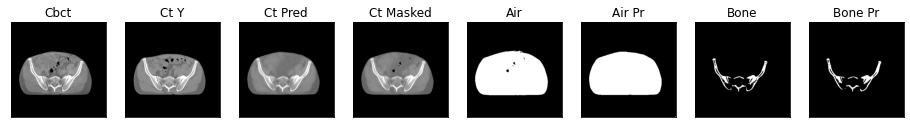

ssim score = 0.8907415866851807
psnr score = 24.08095359802246
snr score = 13.795905113220215
mae error = 0.018661580979824066
air dice score = 0.9909142791918835
bone dice score = 0.9342768049899942


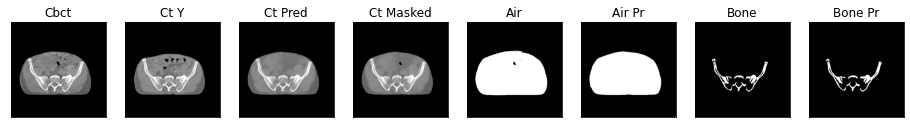

ssim score = 0.8900598287582397
psnr score = 23.9272518157959
snr score = 13.593639373779297
mae error = 0.019289053976535797
air dice score = 0.9922318012078832
bone dice score = 0.9264198666368542


3it [00:27, 12.54s/it]

ssim score = 0.8884192705154419
psnr score = 23.642786026000977
snr score = 13.212173461914062
mae error = 0.01992689073085785
air dice score = 0.9926437962681948
bone dice score = 0.92879256966023


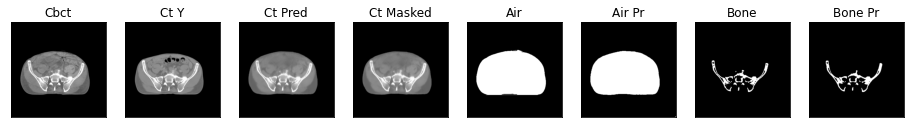

ssim score = 0.8891161680221558
psnr score = 23.79520606994629
snr score = 13.281859397888184
mae error = 0.019341684877872467
air dice score = 0.9922671479281546
bone dice score = 0.9201163571277677


ssim score = 0.888497531414032
psnr score = 23.808643341064453
snr score = 13.204109191894531
mae error = 0.019744539633393288
air dice score = 0.9915927478311829
bone dice score = 0.9171111111120321


ssim score = 0.8903072476387024
psnr score = 23.703441619873047
snr score = 13.057802200317383
mae error = 0.020271191373467445
air dice score = 0.992150667686925
bone dice score = 0.9312929419120207


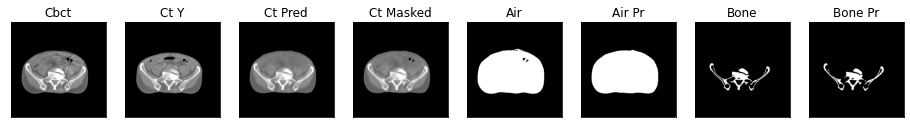

ssim score = 0.8734971284866333
psnr score = 23.954782485961914
snr score = 15.326939582824707
mae error = 0.019887927919626236
air dice score = 0.9923499569491552
bone dice score = 0.9783902286257943


ssim score = 0.8814370632171631
psnr score = 24.865310668945312
snr score = 16.276723861694336
mae error = 0.01795882359147072
air dice score = 0.992134776313534
bone dice score = 0.9751679813036761


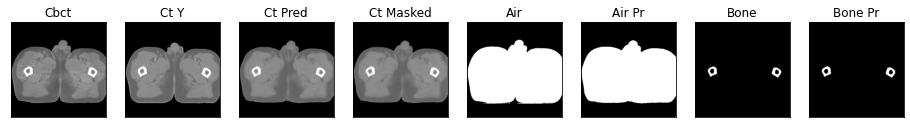

ssim score = 0.8929794430732727
psnr score = 25.59206199645996
snr score = 17.090927124023438
mae error = 0.016736146062612534
air dice score = 0.9925314034382394
bone dice score = 0.9675904180373981


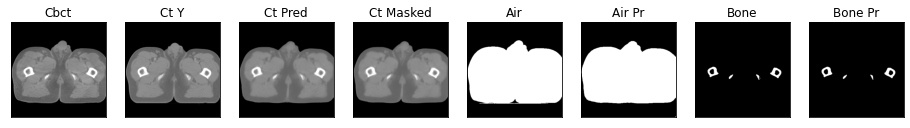

ssim score = 0.8989378809928894
psnr score = 26.447324752807617
snr score = 18.108745574951172
mae error = 0.016475239768624306
air dice score = 0.9936449277557364
bone dice score = 0.9675055750244106


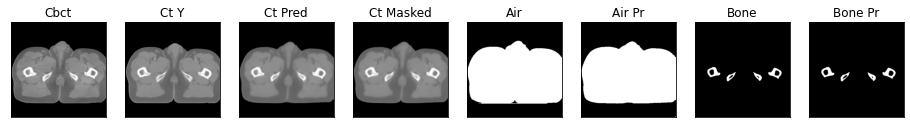

4it [00:30,  9.52s/it]

ssim score = 0.8985012769699097
psnr score = 26.823287963867188
snr score = 18.612850189208984
mae error = 0.016422105953097343
air dice score = 0.9933274961504825
bone dice score = 0.9577309651664914


ssim score = 0.9018071889877319
psnr score = 27.256511688232422
snr score = 19.14931297302246
mae error = 0.016101839020848274
air dice score = 0.9941085942384492
bone dice score = 0.9520743919891264


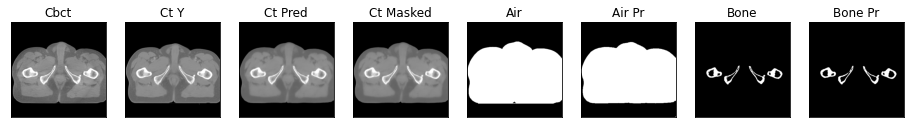

ssim score = 0.9024331569671631
psnr score = 27.63951873779297
snr score = 19.59942054748535
mae error = 0.015866458415985107
air dice score = 0.993739853470641
bone dice score = 0.9430663315490868


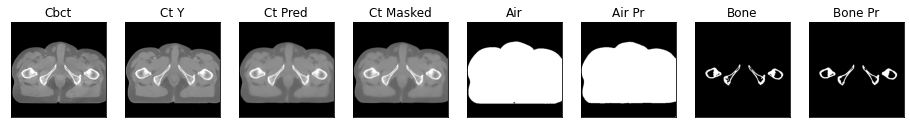

ssim score = 0.9018085598945618
psnr score = 27.669654846191406
snr score = 19.619667053222656
mae error = 0.015738194808363914
air dice score = 0.994280733594425
bone dice score = 0.9599340817802046


ssim score = 0.9056608080863953
psnr score = 27.86991310119629
snr score = 19.806262969970703
mae error = 0.015606777742505074
air dice score = 0.9944400412378539
bone dice score = 0.9600000000004071


ssim score = 0.9065166115760803
psnr score = 28.05353546142578
snr score = 20.00188636779785
mae error = 0.015674568712711334
air dice score = 0.9949094888080147
bone dice score = 0.950844521438384


ssim score = 0.9067392349243164
psnr score = 28.045562744140625
snr score = 20.032997131347656
mae error = 0.01568128913640976
air dice score = 0.9941877413098736
bone dice score = 0.9542774502174405


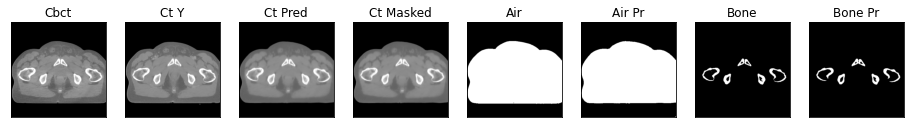

ssim score = 0.9083105325698853
psnr score = 28.217275619506836
snr score = 20.345996856689453
mae error = 0.01593206077814102
air dice score = 0.994676833221322
bone dice score = 0.9550903901050896


5it [00:32,  7.35s/it]

ssim score = 0.9080156683921814
psnr score = 28.4195499420166
snr score = 20.64295768737793
mae error = 0.015996359288692474
air dice score = 0.9954574951330332
bone dice score = 0.9525927102362217


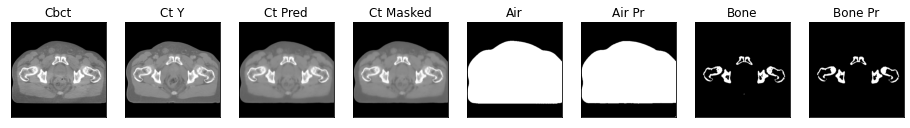

ssim score = 0.9000335931777954
psnr score = 27.645736694335938
snr score = 19.835098266601562
mae error = 0.01743585430085659
air dice score = 0.9945767085160043
bone dice score = 0.9338321253220027


ssim score = 0.9010711908340454
psnr score = 27.806045532226562
snr score = 20.067596435546875
mae error = 0.017284182831645012
air dice score = 0.9930007803589693
bone dice score = 0.9123500545262244


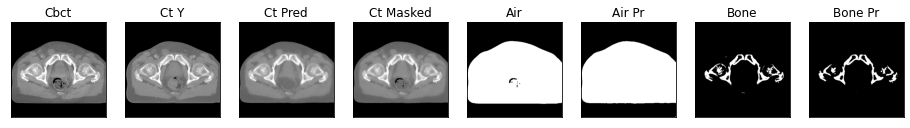

ssim score = 0.8978254795074463
psnr score = 27.63047981262207
snr score = 19.755935668945312
mae error = 0.01703803613781929
air dice score = 0.993888377078106
bone dice score = 0.893039049236949


ssim score = 0.8960540294647217
psnr score = 27.2568359375
snr score = 19.203731536865234
mae error = 0.01694546826183796
air dice score = 0.9932659525594257
bone dice score = 0.8883692557961735


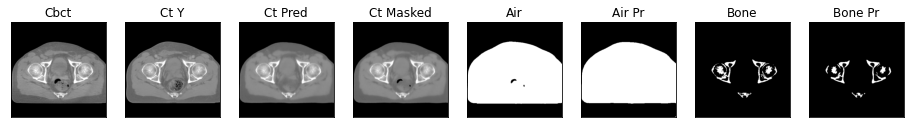

ssim score = 0.8961207866668701
psnr score = 26.743488311767578
snr score = 18.599794387817383
mae error = 0.017477864399552345
air dice score = 0.9943554889989666
bone dice score = 0.8868900382292906


ssim score = 0.8973739147186279
psnr score = 26.532703399658203
snr score = 18.40469741821289
mae error = 0.017558669671416283
air dice score = 0.9948660483188319
bone dice score = 0.8933149698072538


ssim score = 0.8880986571311951
psnr score = 26.481369018554688
snr score = 18.363401412963867
mae error = 0.01847703941166401
air dice score = 0.9943214882968787
bone dice score = 0.9131003550746299


6it [00:35,  5.90s/it]

ssim score = 0.8928447961807251
psnr score = 26.738910675048828
snr score = 18.682533264160156
mae error = 0.017951078712940216
air dice score = 0.9940420927072546
bone dice score = 0.9333697433102733


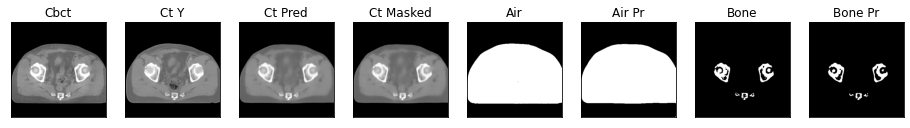

ssim score = 0.8944653272628784
psnr score = 27.442699432373047
snr score = 19.456401824951172
mae error = 0.0175174493342638
air dice score = 0.9934335867413984
bone dice score = 0.9598253275112679


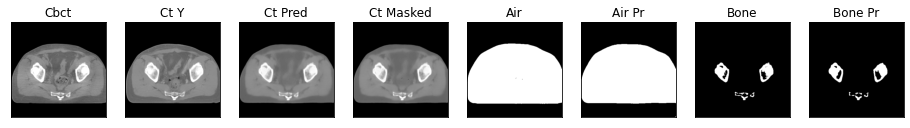

ssim score = 0.8949480652809143
psnr score = 26.887306213378906
snr score = 18.781904220581055
mae error = 0.01802181638777256
air dice score = 0.9928821671765562
bone dice score = 0.9435301074214691


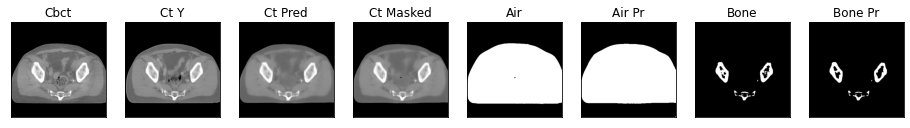

ssim score = 0.8916037082672119
psnr score = 26.537321090698242
snr score = 18.513545989990234
mae error = 0.019385850057005882
air dice score = 0.9926510414102168
bone dice score = 0.9564044185854085


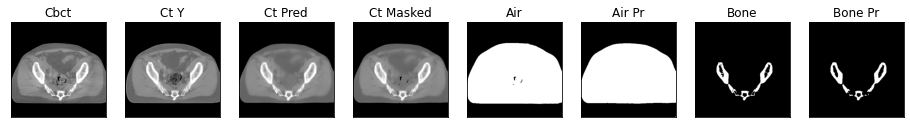

ssim score = 0.8891118764877319
psnr score = 26.68271255493164
snr score = 18.73908233642578
mae error = 0.0194152370095253
air dice score = 0.99118672362155
bone dice score = 0.9537135184795865


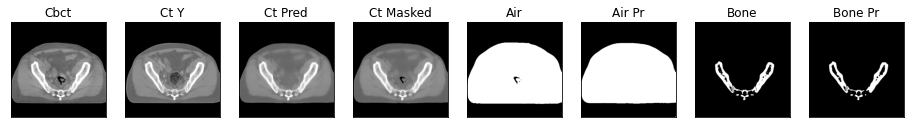

ssim score = 0.8775112628936768
psnr score = 26.217660903930664
snr score = 18.295589447021484
mae error = 0.020866939797997475
air dice score = 0.9904978676799069
bone dice score = 0.9467605633806566


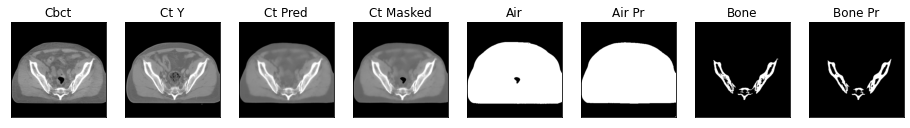

ssim score = 0.8800616264343262
psnr score = 26.18732261657715
snr score = 18.277790069580078
mae error = 0.021116456016898155
air dice score = 0.9916545431303732
bone dice score = 0.9552747408777845


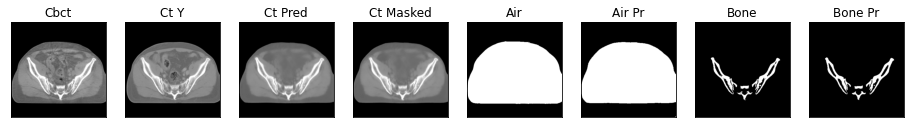

ssim score = 0.8243170380592346
psnr score = 21.277183532714844
snr score = 11.157393455505371
mae error = 0.03067774884402752
air dice score = 0.9920568037151996
bone dice score = 0.9689880304687435


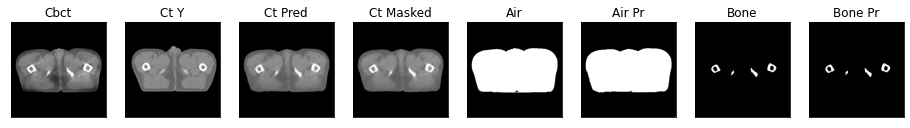

7it [00:37,  4.88s/it]

ssim score = 0.8112667202949524
psnr score = 20.925037384033203
snr score = 11.018226623535156
mae error = 0.03319418802857399
air dice score = 0.9942566546346893
bone dice score = 0.9381465991649098


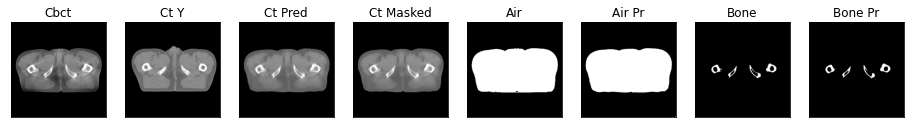

ssim score = 0.8066269159317017
psnr score = 20.962827682495117
snr score = 11.187153816223145
mae error = 0.03341590613126755
air dice score = 0.9935090810877881
bone dice score = 0.9060302578328142


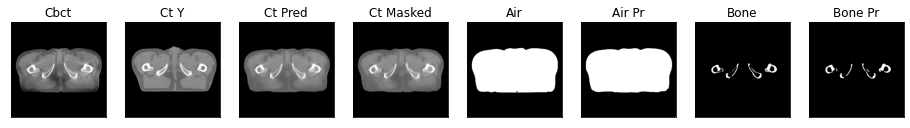

ssim score = 0.810542643070221
psnr score = 21.329357147216797
snr score = 11.624088287353516
mae error = 0.03234032541513443
air dice score = 0.9925619106371794
bone dice score = 0.8987367985111051


ssim score = 0.8108147382736206
psnr score = 21.363018035888672
snr score = 11.705312728881836
mae error = 0.03223491460084915
air dice score = 0.9919665668706557
bone dice score = 0.9001389716120679


ssim score = 0.806771993637085
psnr score = 21.388805389404297
snr score = 11.736719131469727
mae error = 0.03235965222120285
air dice score = 0.99155619722624
bone dice score = 0.9046352583604742


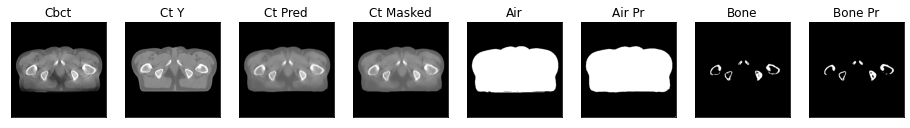

ssim score = 0.8073315620422363
psnr score = 21.42411231994629
snr score = 11.765522003173828
mae error = 0.03189021721482277
air dice score = 0.9916218931551203
bone dice score = 0.9276995305177896


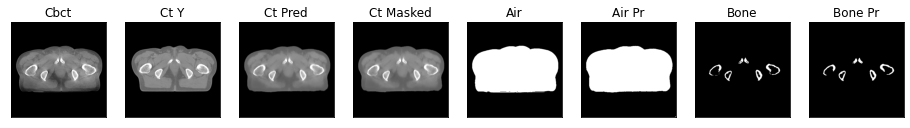

ssim score = 0.8118886947631836
psnr score = 21.38880729675293
snr score = 11.7443265914917
mae error = 0.031725119799375534
air dice score = 0.9920685996556171
bone dice score = 0.9311475409848607


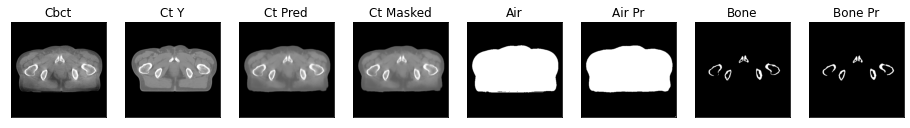

ssim score = 0.8102589249610901
psnr score = 21.264259338378906
snr score = 11.677785873413086
mae error = 0.03273874521255493
air dice score = 0.9916132901106424
bone dice score = 0.9181353977941338


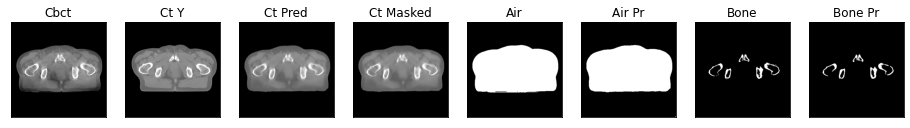

8it [00:39,  4.10s/it]

ssim score = 0.8037605285644531
psnr score = 21.129484176635742
snr score = 11.641570091247559
mae error = 0.03417350724339485
air dice score = 0.9915507604315685
bone dice score = 0.8838187702284171


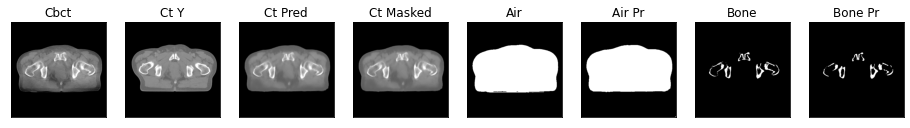

ssim score = 0.7921109795570374
psnr score = 20.907066345214844
snr score = 11.454980850219727
mae error = 0.036080293357372284
air dice score = 0.9907816534109695
bone dice score = 0.8728314499463181


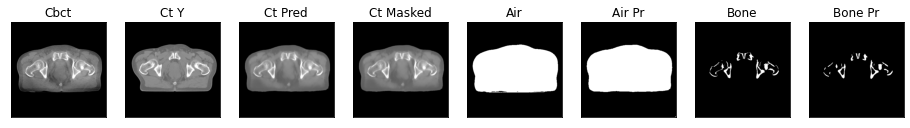

ssim score = 0.7827907204627991
psnr score = 20.81129264831543
snr score = 11.391916275024414
mae error = 0.036707017570734024
air dice score = 0.9913687232975357
bone dice score = 0.8542942600789875


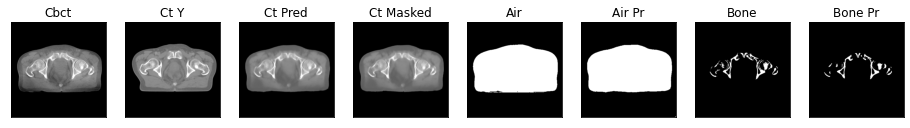

ssim score = 0.7857581973075867
psnr score = 20.909011840820312
snr score = 11.606450080871582
mae error = 0.036554157733917236
air dice score = 0.9926239419588939
bone dice score = 0.8607127644489463


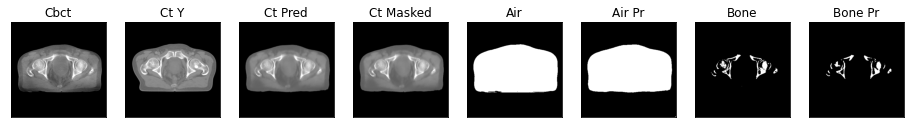

ssim score = 0.7876296639442444
psnr score = 20.810487747192383
snr score = 11.491939544677734
mae error = 0.036507971584796906
air dice score = 0.9923822535040835
bone dice score = 0.8543014996076669


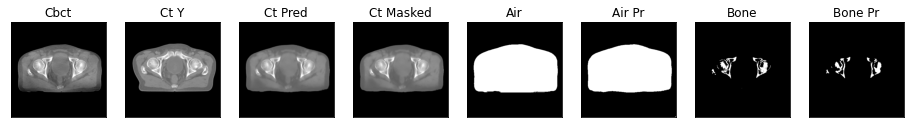

ssim score = 0.8020133376121521
psnr score = 21.35378074645996
snr score = 11.83607006072998
mae error = 0.03348822891712189
air dice score = 0.9926577800785189
bone dice score = 0.8671328671351334


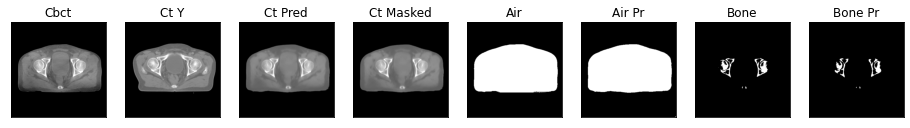

ssim score = 0.8189699649810791
psnr score = 22.08878517150879
snr score = 12.400680541992188
mae error = 0.030104994773864746
air dice score = 0.9923518164436013
bone dice score = 0.9006844106478983


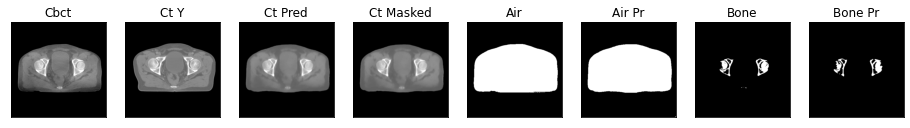

ssim score = 0.8231840133666992
psnr score = 22.42119789123535
snr score = 12.74726390838623
mae error = 0.028437551110982895
air dice score = 0.9915747984061898
bone dice score = 0.9338978421205423


9it [00:42,  3.62s/it]

ssim score = 0.8295636773109436
psnr score = 22.616065979003906
snr score = 13.023959159851074
mae error = 0.02815345674753189
air dice score = 0.9916234954509209
bone dice score = 0.9524840936787263


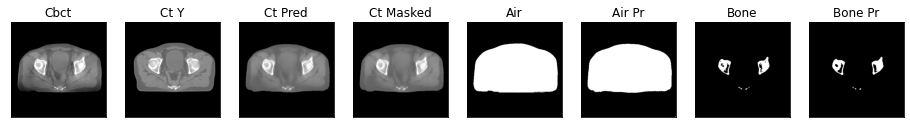

ssim score = 0.8315805196762085
psnr score = 22.652847290039062
snr score = 13.152914047241211
mae error = 0.02835793048143387
air dice score = 0.9928400954654
bone dice score = 0.9404542664220311


ssim score = 0.8281353712081909
psnr score = 22.7962646484375
snr score = 13.232900619506836
mae error = 0.027728641405701637
air dice score = 0.9924451311644806
bone dice score = 0.951227716112492


ssim score = 0.8333977460861206
psnr score = 23.118913650512695
snr score = 13.519158363342285
mae error = 0.026531318202614784
air dice score = 0.991682432547603
bone dice score = 0.9537572254343614


ssim score = 0.8295860290527344
psnr score = 23.03203582763672
snr score = 13.470025062561035
mae error = 0.02757583186030388
air dice score = 0.9912747102931226
bone dice score = 0.9183012109855313


ssim score = 0.8255679607391357
psnr score = 22.794822692871094
snr score = 13.36331844329834
mae error = 0.02864752896130085
air dice score = 0.9911188841018717
bone dice score = 0.920890711984751


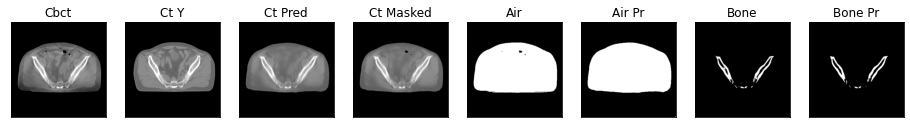

ssim score = 0.8281636238098145
psnr score = 22.701885223388672
snr score = 13.288127899169922
mae error = 0.028919147327542305
air dice score = 0.9898488917873074
bone dice score = 0.9084283903690046


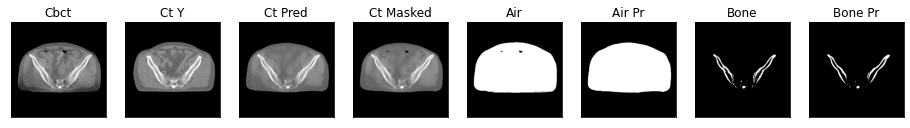

ssim score = 0.83059161901474
psnr score = 22.93838119506836
snr score = 13.513354301452637
mae error = 0.028476102277636528
air dice score = 0.9911454018227086
bone dice score = 0.9179004037698872


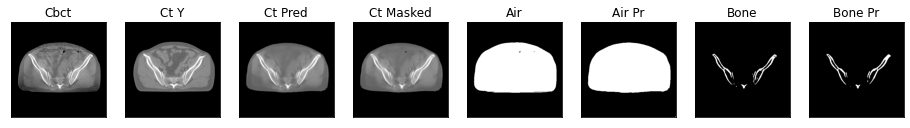

10it [00:44,  3.28s/it]

ssim score = 0.833854079246521
psnr score = 23.03959846496582
snr score = 13.6138334274292
mae error = 0.02782100811600685
air dice score = 0.9906811030106619
bone dice score = 0.888300512992085


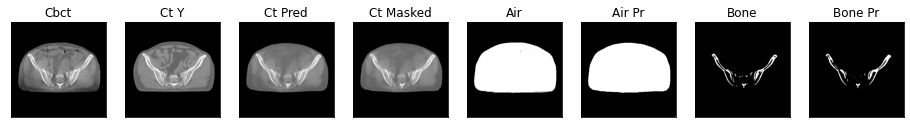

ssim score = 0.8850652575492859
psnr score = 24.530860900878906
snr score = 14.964995384216309
mae error = 0.018065640702843666
air dice score = 0.9929876905648993
bone dice score = 0.9506219374311865


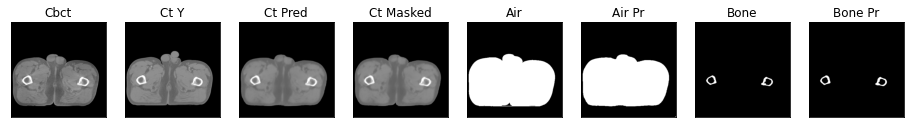

ssim score = 0.8883684873580933
psnr score = 24.964839935302734
snr score = 15.463367462158203
mae error = 0.017352351918816566
air dice score = 0.9929318541996887
bone dice score = 0.946741415558979


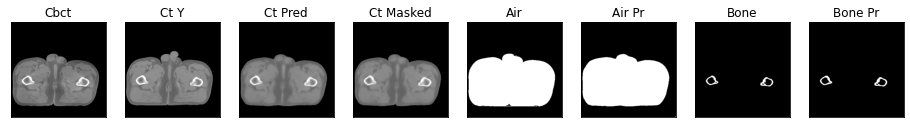

ssim score = 0.8960465788841248
psnr score = 26.854230880737305
snr score = 17.491968154907227
mae error = 0.0162555743008852
air dice score = 0.9928362836361985
bone dice score = 0.9475833900624555


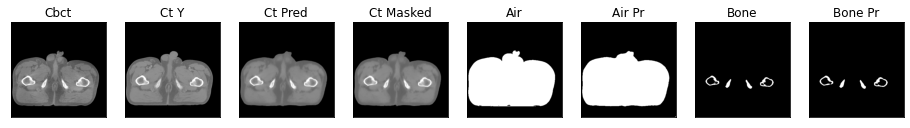

ssim score = 0.8937687277793884
psnr score = 26.500843048095703
snr score = 17.260072708129883
mae error = 0.016950877383351326
air dice score = 0.9953185996236252
bone dice score = 0.9327453142241953


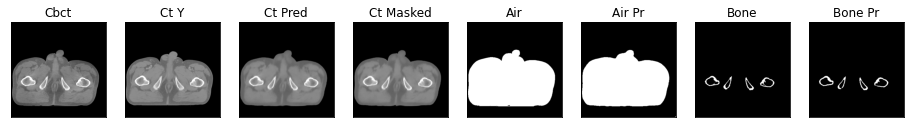

ssim score = 0.8911405801773071
psnr score = 26.359394073486328
snr score = 17.14279556274414
mae error = 0.017413798719644547
air dice score = 0.9951912245674859
bone dice score = 0.9189814814833569


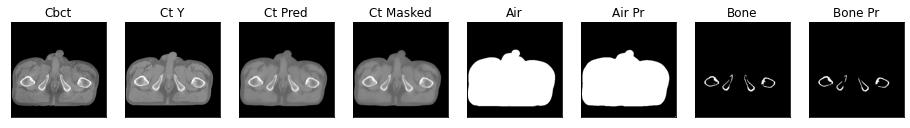

ssim score = 0.8929101824760437
psnr score = 26.193485260009766
snr score = 16.97249412536621
mae error = 0.017017031088471413
air dice score = 0.9956175391512797
bone dice score = 0.9043072353086292


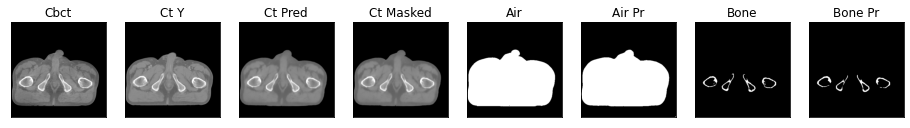

ssim score = 0.8935487866401672
psnr score = 25.80669403076172
snr score = 16.591955184936523
mae error = 0.017356010153889656
air dice score = 0.9958007933556497
bone dice score = 0.8986402966646345


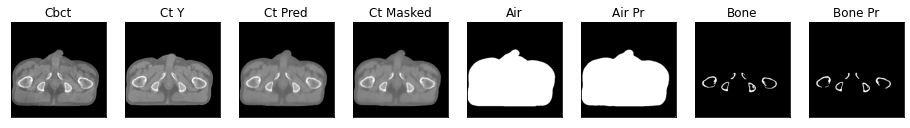

11it [00:47,  2.98s/it]

ssim score = 0.8918371200561523
psnr score = 25.5553035736084
snr score = 16.31900978088379
mae error = 0.01727111078798771
air dice score = 0.9958845819356473
bone dice score = 0.9140326152624515


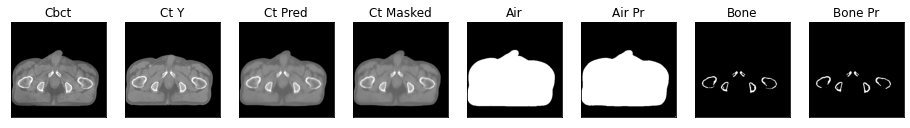

ssim score = 0.892029345035553
psnr score = 25.574039459228516
snr score = 16.354656219482422
mae error = 0.016777141019701958
air dice score = 0.9959780621572243
bone dice score = 0.9243635012093595


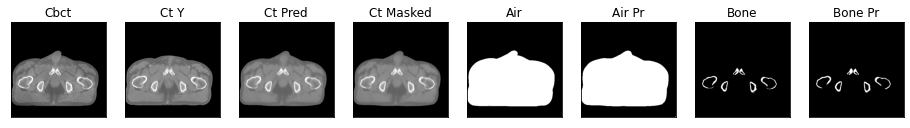

ssim score = 0.8938295841217041
psnr score = 26.004581451416016
snr score = 16.853792190551758
mae error = 0.016611220315098763
air dice score = 0.9960407018968739
bone dice score = 0.9259196473991198


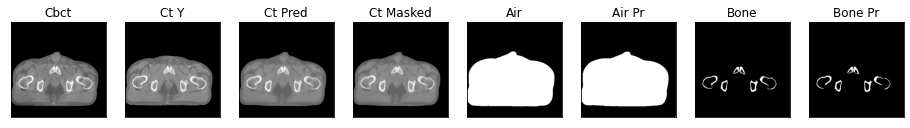

ssim score = 0.8956519961357117
psnr score = 26.647518157958984
snr score = 17.57808494567871
mae error = 0.015982218086719513
air dice score = 0.9956332562424086
bone dice score = 0.9177135678404882


ssim score = 0.8948044776916504
psnr score = 26.96703338623047
snr score = 17.948305130004883
mae error = 0.015910500660538673
air dice score = 0.995502437490175
bone dice score = 0.8807596513094527


ssim score = 0.8966960906982422
psnr score = 27.37154769897461
snr score = 18.469085693359375
mae error = 0.015545603819191456
air dice score = 0.9959881223148882
bone dice score = 0.8628530050707769


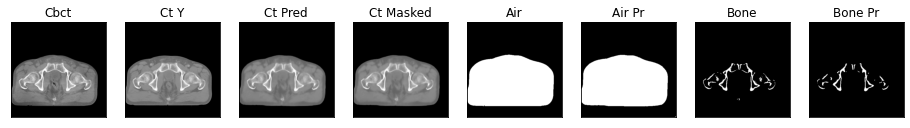

ssim score = 0.8977628946304321
psnr score = 27.739944458007812
snr score = 18.79924774169922
mae error = 0.015235796570777893
air dice score = 0.9952028671788933
bone dice score = 0.8456162642972425


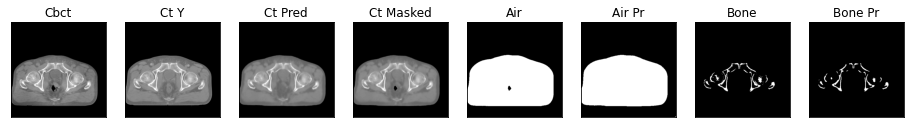

ssim score = 0.8949784636497498
psnr score = 27.4533634185791
snr score = 18.416994094848633
mae error = 0.015473870560526848
air dice score = 0.9926484087516722
bone dice score = 0.8201310303779016


12it [00:49,  2.84s/it]

ssim score = 0.9011486768722534
psnr score = 28.068342208862305
snr score = 18.872217178344727
mae error = 0.014635269530117512
air dice score = 0.9894910927176327
bone dice score = 0.837387964151502


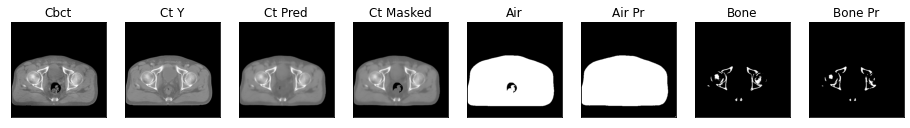

ssim score = 0.900865375995636
psnr score = 27.56305694580078
snr score = 18.250507354736328
mae error = 0.014542332850396633
air dice score = 0.9877007036266425
bone dice score = 0.8376745941895494


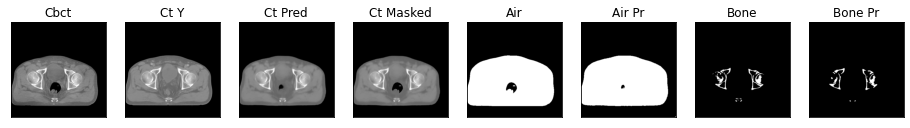

ssim score = 0.8933838605880737
psnr score = 26.606952667236328
snr score = 17.24930763244629
mae error = 0.01566561684012413
air dice score = 0.9885436655371016
bone dice score = 0.86412000697952


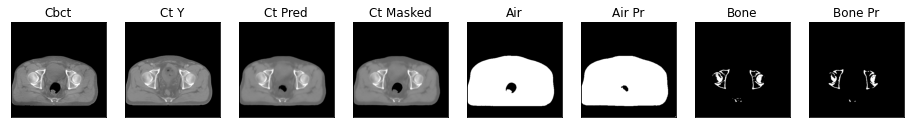

ssim score = 0.8881598711013794
psnr score = 26.295568466186523
snr score = 16.944595336914062
mae error = 0.01665126532316208
air dice score = 0.9871327436522186
bone dice score = 0.9072614455826385


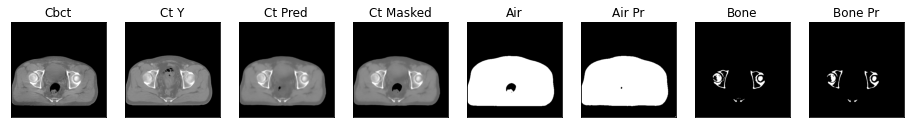

ssim score = 0.8870130777359009
psnr score = 25.35487174987793
snr score = 16.03400421142578
mae error = 0.018181366845965385
air dice score = 0.9896393442623036
bone dice score = 0.9394216133951382


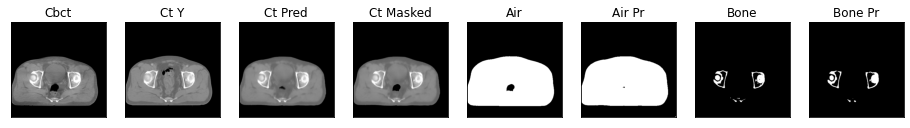

ssim score = 0.8903799057006836
psnr score = 25.390188217163086
snr score = 16.0267333984375
mae error = 0.01779852993786335
air dice score = 0.9918897132610658
bone dice score = 0.9297647459950603


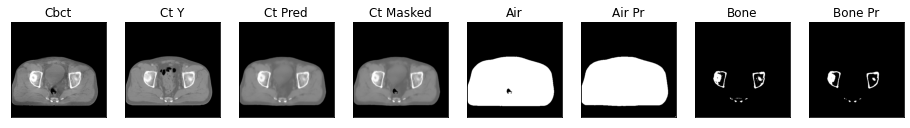

ssim score = 0.8898292183876038
psnr score = 25.241701126098633
snr score = 15.788043975830078
mae error = 0.017571646720170975
air dice score = 0.9935346253059119
bone dice score = 0.9126662810890174


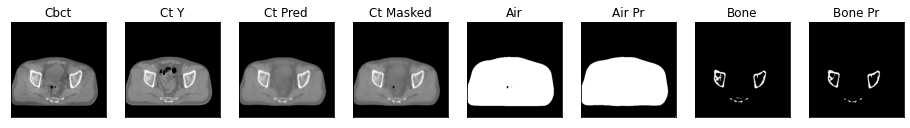

ssim score = 0.8925735950469971
psnr score = 25.2879695892334
snr score = 15.768585205078125
mae error = 0.017502395436167717
air dice score = 0.9920969397548198
bone dice score = 0.9349930843719622


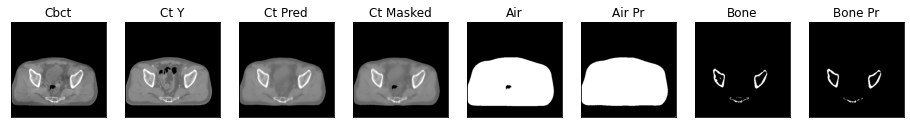

13it [00:52,  2.73s/it]

ssim score = 0.8905643224716187
psnr score = 25.493297576904297
snr score = 15.973610877990723
mae error = 0.017020268365740776
air dice score = 0.9917108028583508
bone dice score = 0.9290953545244657


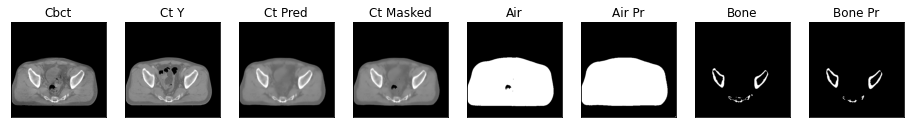

ssim score = 0.8849362134933472
psnr score = 25.427656173706055
snr score = 15.984135627746582
mae error = 0.01803993247449398
air dice score = 0.9899324301382042
bone dice score = 0.9075407908289351


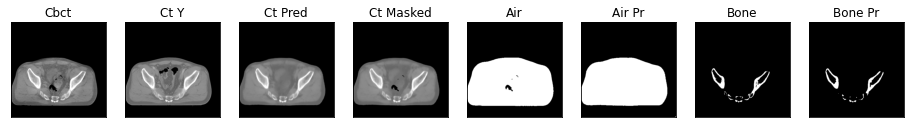

ssim score = 0.888132631778717
psnr score = 25.45014190673828
snr score = 16.042203903198242
mae error = 0.017970643937587738
air dice score = 0.990244945069046
bone dice score = 0.9201191443281869


ssim score = 0.8885686993598938
psnr score = 25.43026351928711
snr score = 15.960626602172852
mae error = 0.017903242260217667
air dice score = 0.990592370515877
bone dice score = 0.9046594982092522


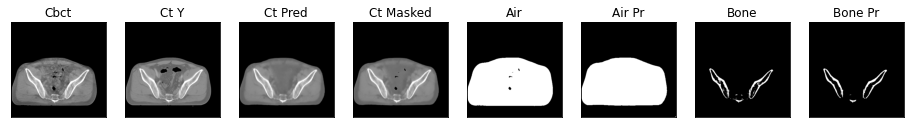

ssim score = 0.8848933577537537
psnr score = 25.151775360107422
snr score = 15.62087631225586
mae error = 0.01835235022008419
air dice score = 0.9905174137136881
bone dice score = 0.9023508137446903


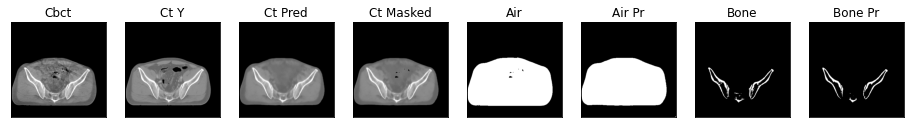

ssim score = 0.8272864818572998
psnr score = 23.070621490478516
snr score = 14.767928123474121
mae error = 0.026821382343769073
air dice score = 0.9923528260134479
bone dice score = 0.968982630273915


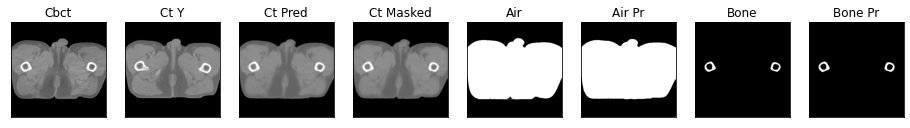

ssim score = 0.8183503746986389
psnr score = 22.601030349731445
snr score = 14.402626037597656
mae error = 0.0288397166877985
air dice score = 0.9927354768598403
bone dice score = 0.9655558667049691


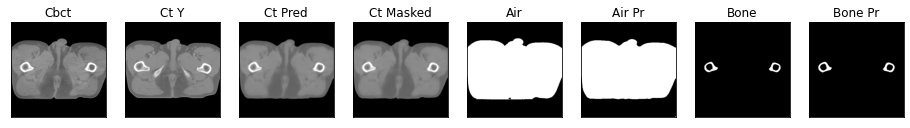

ssim score = 0.8096122145652771
psnr score = 22.153160095214844
snr score = 14.08271312713623
mae error = 0.03152436017990112
air dice score = 0.9935648572974791
bone dice score = 0.9472259810566706


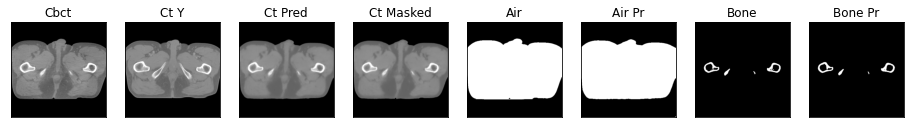

14it [00:54,  2.60s/it]

ssim score = 0.8007355332374573
psnr score = 21.775054931640625
snr score = 13.736900329589844
mae error = 0.03209860250353813
air dice score = 0.9942511878923012
bone dice score = 0.948529411765566


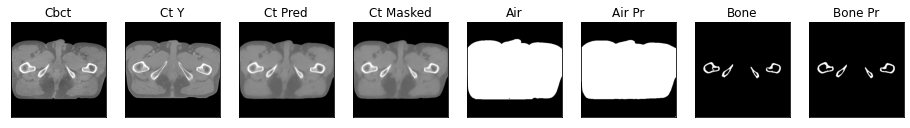

ssim score = 0.7906700372695923
psnr score = 21.621530532836914
snr score = 13.61361312866211
mae error = 0.03306260332465172
air dice score = 0.9951556446381955
bone dice score = 0.9226736566198775


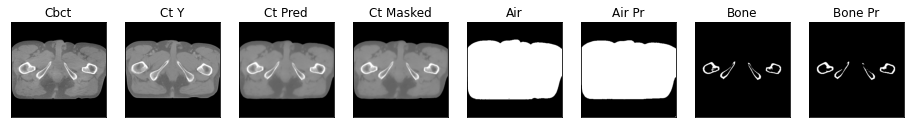

ssim score = 0.7824834585189819
psnr score = 21.591449737548828
snr score = 13.61794662475586
mae error = 0.03384638950228691
air dice score = 0.9954042672165263
bone dice score = 0.924209207642903


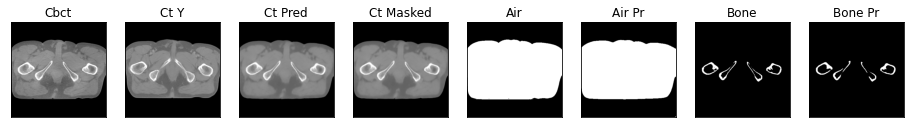

ssim score = 0.7739139199256897
psnr score = 21.21722984313965
snr score = 13.264037132263184
mae error = 0.03563414886593819
air dice score = 0.9954052329291667
bone dice score = 0.92789711314916


ssim score = 0.7743355631828308
psnr score = 21.316028594970703
snr score = 13.401909828186035
mae error = 0.035037342458963394
air dice score = 0.9942187146642887
bone dice score = 0.9189411603357709


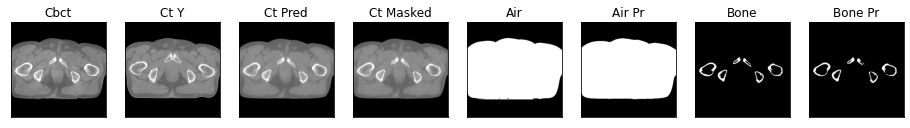

ssim score = 0.7715112566947937
psnr score = 21.357162475585938
snr score = 13.491724014282227
mae error = 0.03509547933936119
air dice score = 0.9946141907387277
bone dice score = 0.9271664008515794


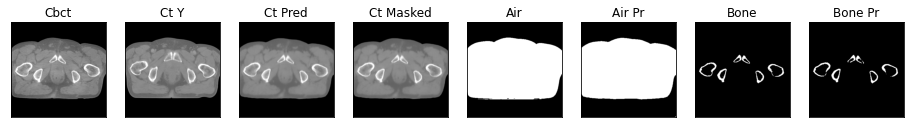

ssim score = 0.7637074589729309
psnr score = 21.16827392578125
snr score = 13.325448036193848
mae error = 0.03694234788417816
air dice score = 0.9948305172952187
bone dice score = 0.9274040288872748


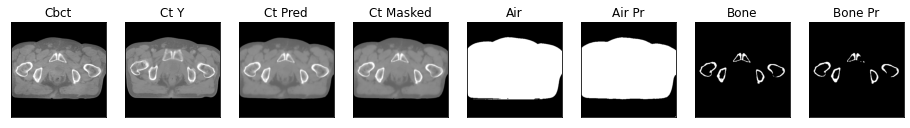

ssim score = 0.7511101961135864
psnr score = 21.08061981201172
snr score = 13.280571937561035
mae error = 0.03853457421064377
air dice score = 0.9951530818321379
bone dice score = 0.9041525832942521


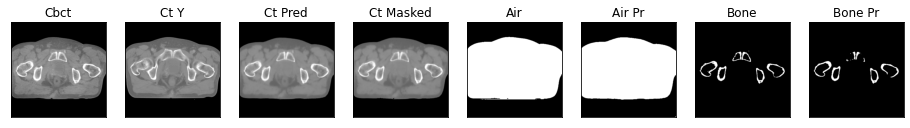

15it [00:56,  2.57s/it]

ssim score = 0.7538505792617798
psnr score = 21.176437377929688
snr score = 13.434728622436523
mae error = 0.03812519088387489
air dice score = 0.9958088755253303
bone dice score = 0.9142794424331656


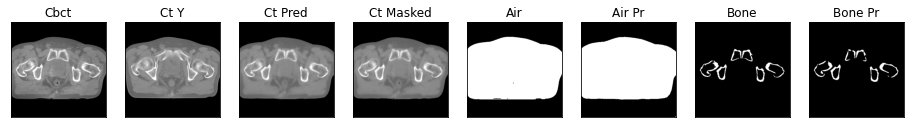

ssim score = 0.7498248815536499
psnr score = 20.95602798461914
snr score = 13.138943672180176
mae error = 0.040013838559389114
air dice score = 0.9966443338657983
bone dice score = 0.8978221046214347


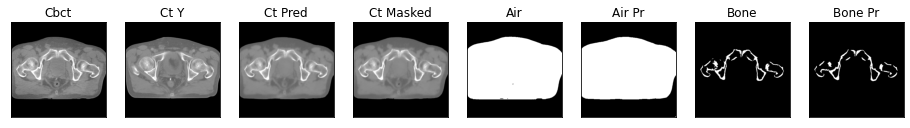

ssim score = 0.7560285329818726
psnr score = 20.917253494262695
snr score = 12.992950439453125
mae error = 0.040608447045087814
air dice score = 0.9961367320892713
bone dice score = 0.8715984680520903


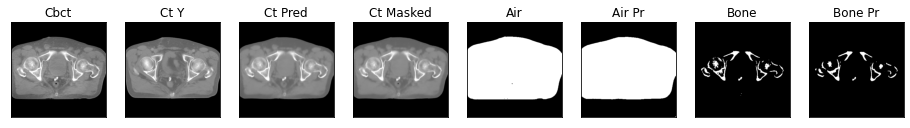

ssim score = 0.7688258290290833
psnr score = 21.15644073486328
snr score = 13.109052658081055
mae error = 0.03913681581616402
air dice score = 0.9960858803891118
bone dice score = 0.8349715468201244


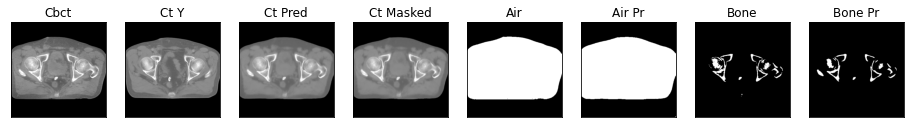

ssim score = 0.7705232501029968
psnr score = 21.311573028564453
snr score = 13.151755332946777
mae error = 0.037856992334127426
air dice score = 0.9962801695550643
bone dice score = 0.864760681016546


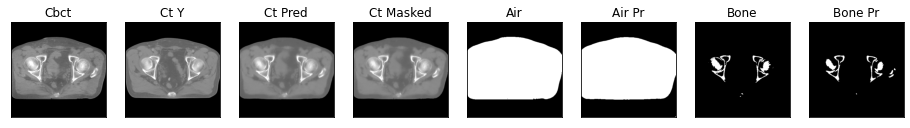

ssim score = 0.7718796133995056
psnr score = 21.66551971435547
snr score = 13.455055236816406
mae error = 0.034820739179849625
air dice score = 0.9965632557655165
bone dice score = 0.893337638576113


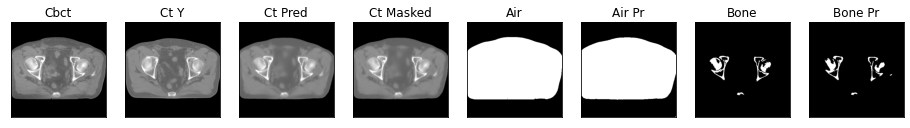

ssim score = 0.7703917622566223
psnr score = 21.49295425415039
snr score = 13.314643859863281
mae error = 0.03627273812890053
air dice score = 0.9963885921315456
bone dice score = 0.8931073446339761


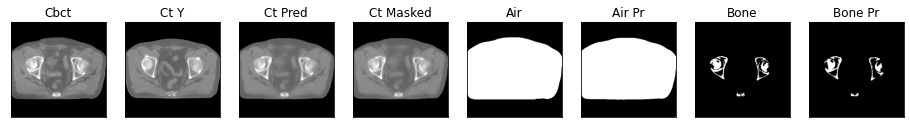

ssim score = 0.7730309963226318
psnr score = 21.38204574584961
snr score = 13.217211723327637
mae error = 0.03682379052042961
air dice score = 0.9955367300859425
bone dice score = 0.9012148729917632


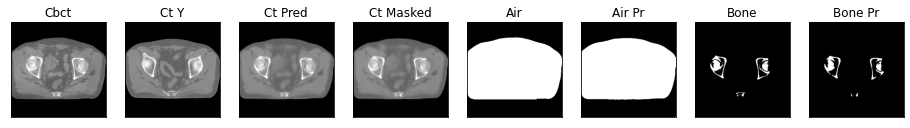

16it [00:59,  2.55s/it]

ssim score = 0.7704851031303406
psnr score = 20.9577579498291
snr score = 12.651433944702148
mae error = 0.038464102894067764
air dice score = 0.9958805777738736
bone dice score = 0.9275086299258717


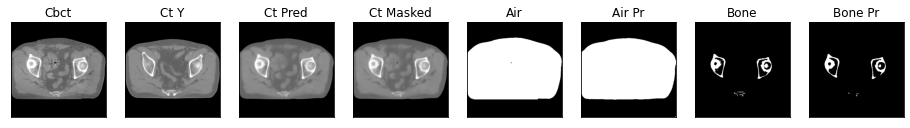

ssim score = 0.7825901508331299
psnr score = 21.081825256347656
snr score = 12.716192245483398
mae error = 0.03757144510746002
air dice score = 0.9954545186565211
bone dice score = 0.9223099293737389


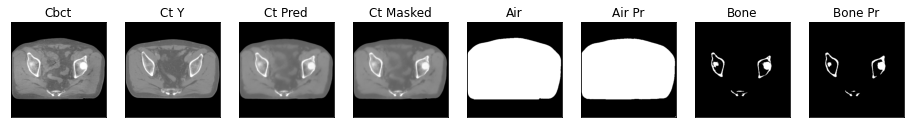

ssim score = 0.7827606201171875
psnr score = 21.39507293701172
snr score = 13.055086135864258
mae error = 0.03555268049240112
air dice score = 0.9953954191235324
bone dice score = 0.907820686980248


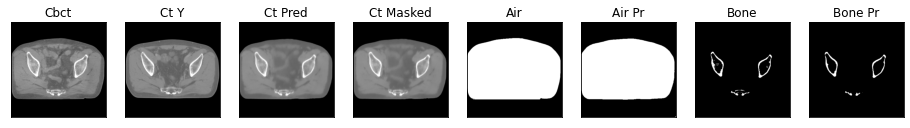

ssim score = 0.7751982808113098
psnr score = 21.31781578063965
snr score = 13.050642967224121
mae error = 0.0359814390540123
air dice score = 0.9956067767552084
bone dice score = 0.9181608379208563


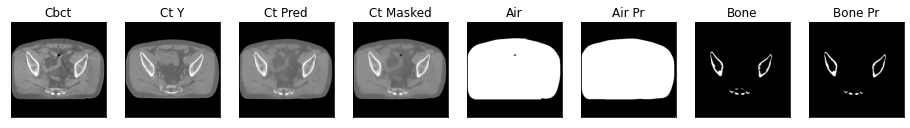

ssim score = 0.7724777460098267
psnr score = 21.124868392944336
snr score = 12.986926078796387
mae error = 0.03756696730852127
air dice score = 0.9946581068618207
bone dice score = 0.9190175904427644


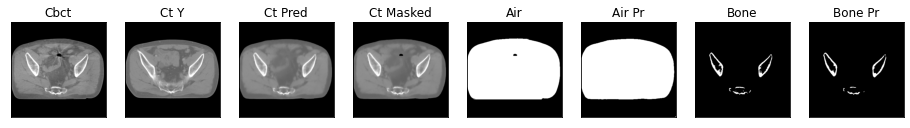

ssim score = 0.766482412815094
psnr score = 20.999528884887695
snr score = 12.895545959472656
mae error = 0.038333747535943985
air dice score = 0.9935306660884061
bone dice score = 0.9102525098888006


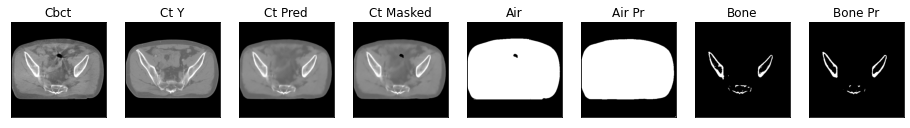

ssim score = 0.754328727722168
psnr score = 20.812496185302734
snr score = 12.678723335266113
mae error = 0.039626676589250565
air dice score = 0.9943173574503106
bone dice score = 0.9002998500762082


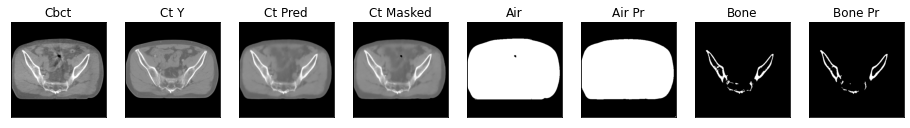

ssim score = 0.7548226118087769
psnr score = 21.155261993408203
snr score = 12.958112716674805
mae error = 0.03771194443106651
air dice score = 0.9940484143275352
bone dice score = 0.8989126057202455


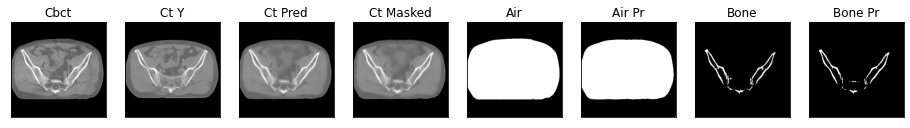

17it [01:01,  2.47s/it]

ssim score = 0.861393928527832
psnr score = 24.114744186401367
snr score = 15.59213638305664
mae error = 0.02250528708100319
air dice score = 0.995040463286068
bone dice score = 0.9008009858299346


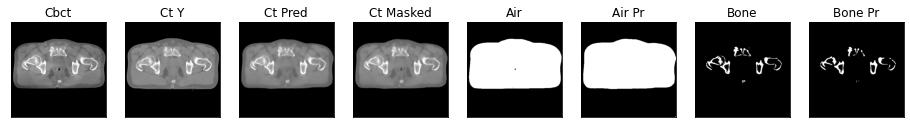

ssim score = 0.8624494075775146
psnr score = 24.178543090820312
snr score = 15.695947647094727
mae error = 0.022158371284604073
air dice score = 0.994427456494733
bone dice score = 0.8877947654847397


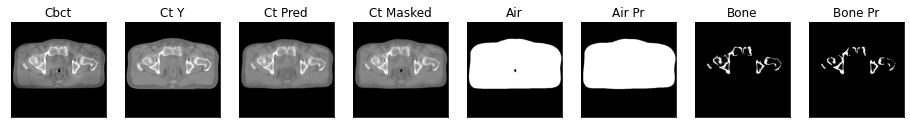

ssim score = 0.8609812259674072
psnr score = 24.134864807128906
snr score = 15.660053253173828
mae error = 0.022931834682822227
air dice score = 0.9946932995453569
bone dice score = 0.8568657336863397


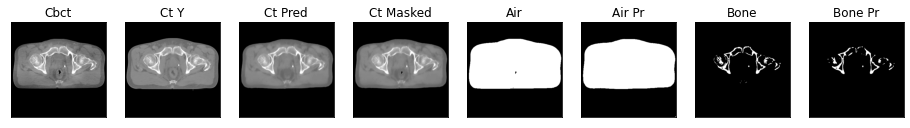

ssim score = 0.8643902540206909
psnr score = 24.146793365478516
snr score = 15.613561630249023
mae error = 0.022286908701062202
air dice score = 0.9947830246498387
bone dice score = 0.835088654848219


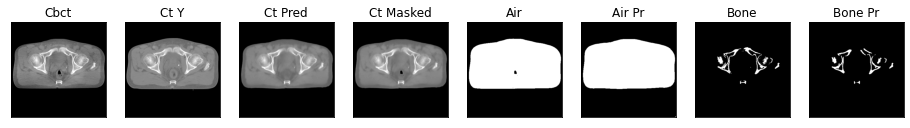

ssim score = 0.8686509728431702
psnr score = 24.286497116088867
snr score = 15.597643852233887
mae error = 0.020850107073783875
air dice score = 0.9939570243968316
bone dice score = 0.8627819548893675


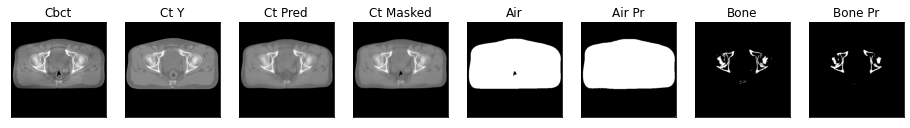

ssim score = 0.8710839152336121
psnr score = 24.380386352539062
snr score = 15.670726776123047
mae error = 0.020566608756780624
air dice score = 0.9950915172698951
bone dice score = 0.8891465005087792


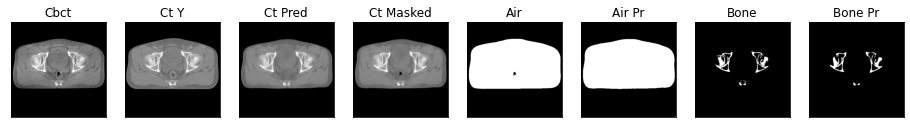

ssim score = 0.8725488185882568
psnr score = 24.075727462768555
snr score = 15.350440979003906
mae error = 0.021177031099796295
air dice score = 0.9934505238825525
bone dice score = 0.8973297158375363


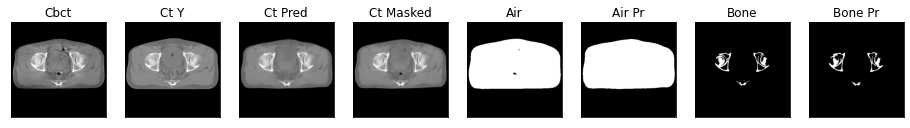

ssim score = 0.8685781955718994
psnr score = 23.524484634399414
snr score = 14.808563232421875
mae error = 0.0221987497061491
air dice score = 0.9914685611925862
bone dice score = 0.8976579134152213


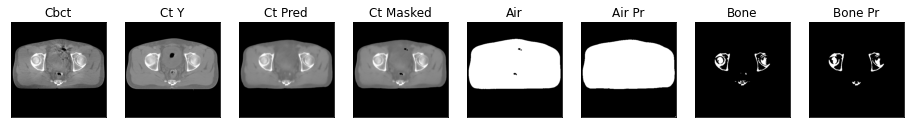

18it [01:04,  2.48s/it]

ssim score = 0.8677879571914673
psnr score = 23.369997024536133
snr score = 14.709856033325195
mae error = 0.023202963173389435
air dice score = 0.9913449900661562
bone dice score = 0.9184525466195596


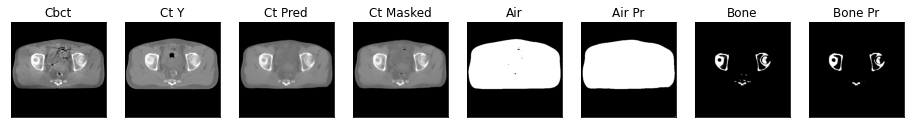

ssim score = 0.8647027015686035
psnr score = 23.02739715576172
snr score = 14.345325469970703
mae error = 0.024080051109194756
air dice score = 0.9916220530170602
bone dice score = 0.9239716312067522


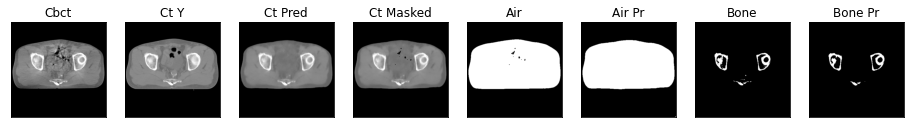

ssim score = 0.8648471236228943
psnr score = 22.817459106445312
snr score = 14.064613342285156
mae error = 0.024273544549942017
air dice score = 0.9916447766452042
bone dice score = 0.8895745371891917


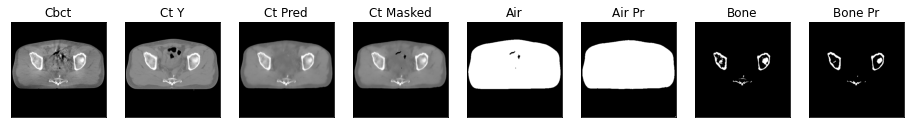

ssim score = 0.862189769744873
psnr score = 22.8983154296875
snr score = 14.101576805114746
mae error = 0.024131884798407555
air dice score = 0.9923801192476865
bone dice score = 0.8907188196965051


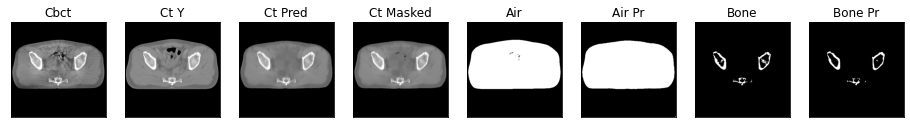

ssim score = 0.8634511828422546
psnr score = 23.19818878173828
snr score = 14.400352478027344
mae error = 0.023532547056674957
air dice score = 0.9914192842728025
bone dice score = 0.9108227952059317


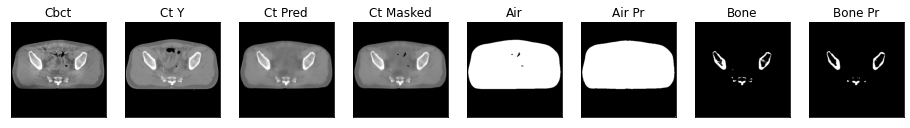

ssim score = 0.865615963935852
psnr score = 23.595932006835938
snr score = 14.811453819274902
mae error = 0.022435493767261505
air dice score = 0.9901438609782004
bone dice score = 0.9203980099514864


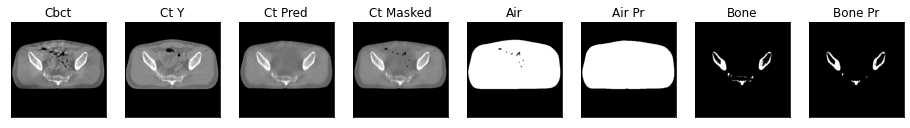

ssim score = 0.8627402186393738
psnr score = 23.763959884643555
snr score = 15.034685134887695
mae error = 0.022717902436852455
air dice score = 0.9884383650871283
bone dice score = 0.927303356227455


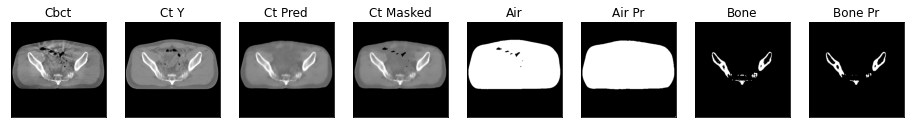

ssim score = 0.8632678985595703
psnr score = 23.578271865844727
snr score = 14.868366241455078
mae error = 0.022951258346438408
air dice score = 0.9891355838750094
bone dice score = 0.9206560874793885


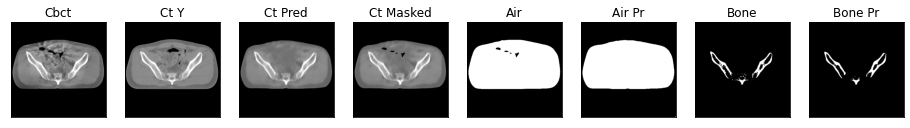

19it [01:06,  2.48s/it]

ssim score = 0.8638046979904175
psnr score = 23.15323257446289
snr score = 14.388590812683105
mae error = 0.023683171719312668
air dice score = 0.9902978987843319
bone dice score = 0.9057491545374835


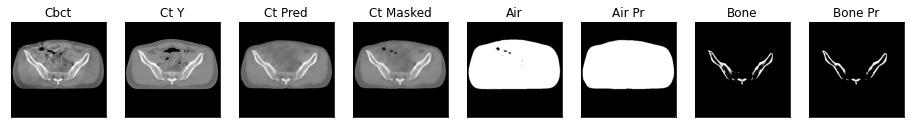

ssim score = 0.8622561097145081
psnr score = 22.98517417907715
snr score = 14.184179306030273
mae error = 0.024096226319670677
air dice score = 0.9926753299208557
bone dice score = 0.8864414347390022


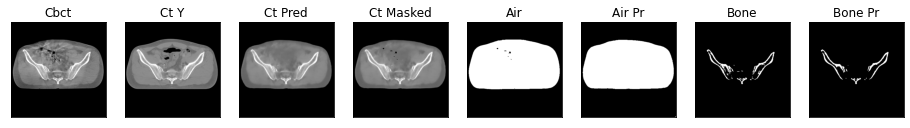

ssim score = 0.8645209074020386
psnr score = 23.02072525024414
snr score = 14.219799995422363
mae error = 0.024064207449555397
air dice score = 0.9924174670451511
bone dice score = 0.8883591577289318


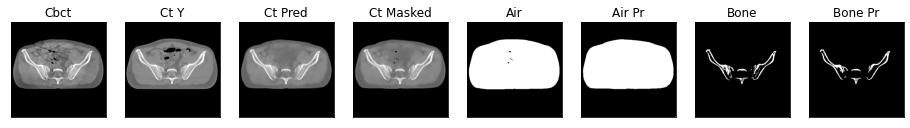

ssim score = 0.8680324554443359
psnr score = 23.609790802001953
snr score = 14.80744457244873
mae error = 0.02273528091609478
air dice score = 0.9933491501691935
bone dice score = 0.8788083953977142


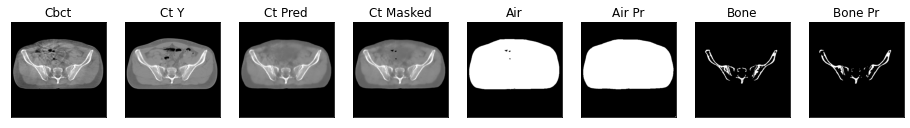

ssim score = 0.8641777634620667
psnr score = 23.28018569946289
snr score = 14.482879638671875
mae error = 0.024017877876758575
air dice score = 0.9912811346233471
bone dice score = 0.8773610730922891


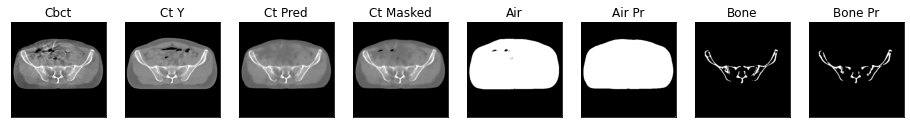

ssim score = 0.8608100414276123
psnr score = 23.178064346313477
snr score = 14.363485336303711
mae error = 0.024870114400982857
air dice score = 0.9904073361188126
bone dice score = 0.8691351045807075


ssim score = 0.8545413017272949
psnr score = 22.537445068359375
snr score = 13.704242706298828
mae error = 0.02644289843738079
air dice score = 0.9880454273759807
bone dice score = 0.8613770491821459


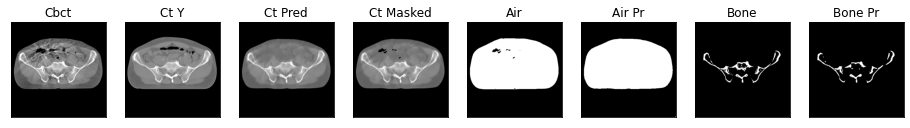

ssim score = 0.8464754819869995
psnr score = 22.21402359008789
snr score = 13.334880828857422
mae error = 0.02767184190452099
air dice score = 0.9881903740109432
bone dice score = 0.8398595030591927


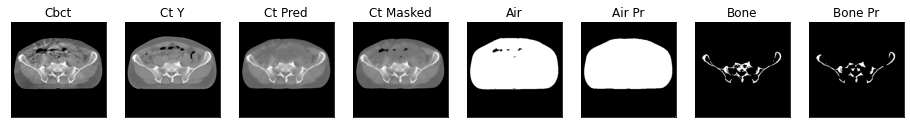

20it [01:09,  2.42s/it]

ssim score = 0.8451594114303589
psnr score = 22.20012855529785
snr score = 13.267190933227539
mae error = 0.02856830693781376
air dice score = 0.9859264307336435
bone dice score = 0.8729405891179114


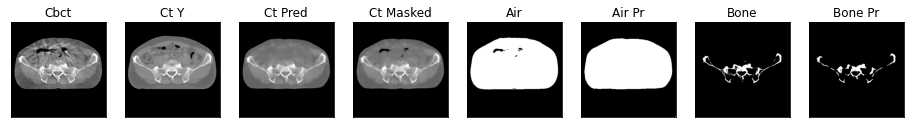

ssim score = 0.840229868888855
psnr score = 21.875198364257812
snr score = 12.972721099853516
mae error = 0.029870914295315742
air dice score = 0.9846579656892107
bone dice score = 0.8832425892331125


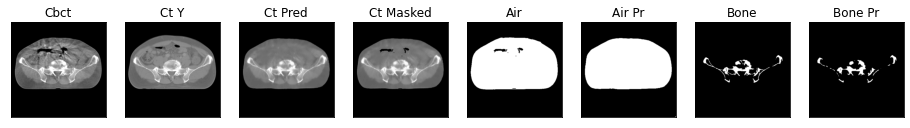

ssim score = 0.8367605209350586
psnr score = 21.499774932861328
snr score = 12.542071342468262
mae error = 0.030564947053790092
air dice score = 0.9856939053645977
bone dice score = 0.8669385674245865


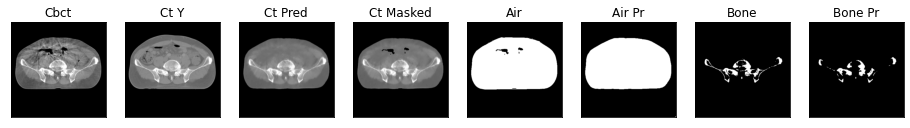

ssim score = 0.8444830179214478
psnr score = 22.179651260375977
snr score = 13.074416160583496
mae error = 0.028192277997732162
air dice score = 0.9862991836962789
bone dice score = 0.882875712960832


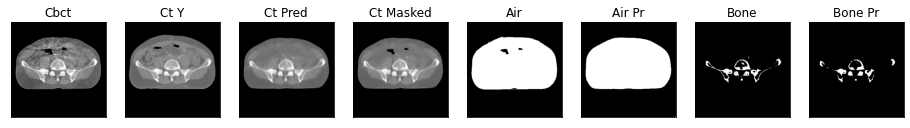

ssim score = 0.8905771970748901
psnr score = 26.781463623046875
snr score = 17.162376403808594
mae error = 0.014676087535917759
air dice score = 0.9941033389843045
bone dice score = 0.9517876489720534


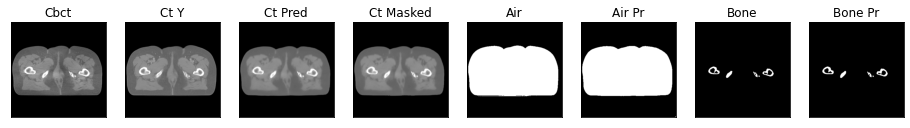

ssim score = 0.8910255432128906
psnr score = 27.00334930419922
snr score = 17.50527572631836
mae error = 0.014677907340228558
air dice score = 0.9941738761289988
bone dice score = 0.9529895025113421


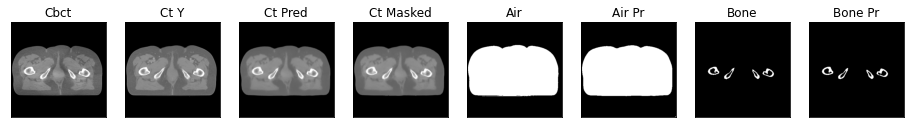

ssim score = 0.8856345415115356
psnr score = 26.816402435302734
snr score = 17.4012451171875
mae error = 0.015305018983781338
air dice score = 0.9942852150870364
bone dice score = 0.9361613641102898


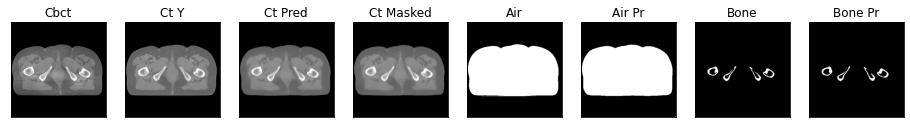

ssim score = 0.8802869915962219
psnr score = 26.51951026916504
snr score = 17.167797088623047
mae error = 0.015696266666054726
air dice score = 0.9941427204453894
bone dice score = 0.9385245901650796


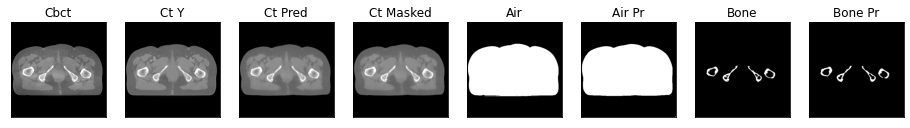

21it [01:11,  2.44s/it]

ssim score = 0.8786977529525757
psnr score = 26.25259017944336
snr score = 16.929336547851562
mae error = 0.016094418242573738
air dice score = 0.9938691113103373
bone dice score = 0.9403063919714685


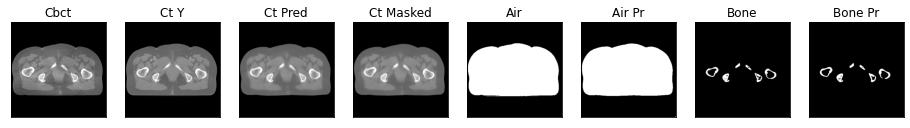

ssim score = 0.8794092535972595
psnr score = 26.0305118560791
snr score = 16.730213165283203
mae error = 0.016380198299884796
air dice score = 0.9935166554884911
bone dice score = 0.9320175438608915


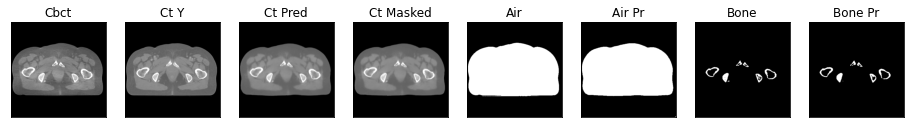

ssim score = 0.878460705280304
psnr score = 26.126853942871094
snr score = 16.857885360717773
mae error = 0.01641746796667576
air dice score = 0.9942988604910354
bone dice score = 0.9365136298433193


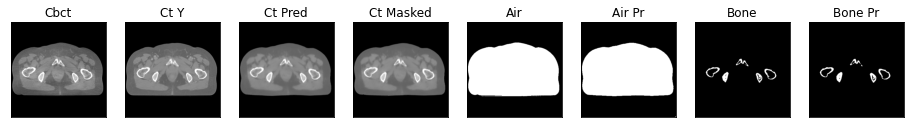

ssim score = 0.8795327544212341
psnr score = 26.234142303466797
snr score = 17.013538360595703
mae error = 0.01663440838456154
air dice score = 0.9943361688381649
bone dice score = 0.9319521343109135


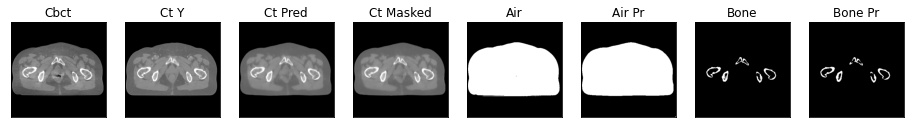

ssim score = 0.8811016082763672
psnr score = 26.229087829589844
snr score = 17.051225662231445
mae error = 0.0165546927601099
air dice score = 0.9933582727200972
bone dice score = 0.9267553460190814


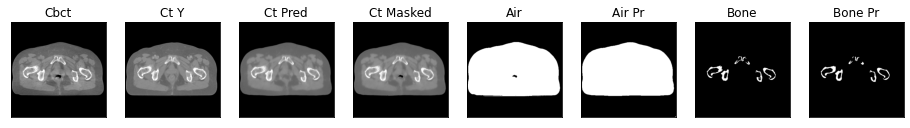

ssim score = 0.8813059329986572
psnr score = 26.397716522216797
snr score = 17.307554244995117
mae error = 0.016564443707466125
air dice score = 0.9931884016405246
bone dice score = 0.9056603773598704


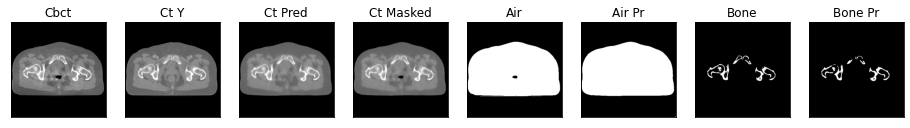

ssim score = 0.8825455904006958
psnr score = 26.696060180664062
snr score = 17.71917152404785
mae error = 0.016451889649033546
air dice score = 0.9933423436952543
bone dice score = 0.9150436133359415


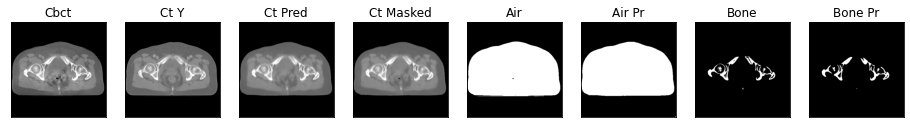

ssim score = 0.8868093490600586
psnr score = 27.121334075927734
snr score = 18.01589584350586
mae error = 0.015799934044480324
air dice score = 0.9920234436423472
bone dice score = 0.8905084157575827


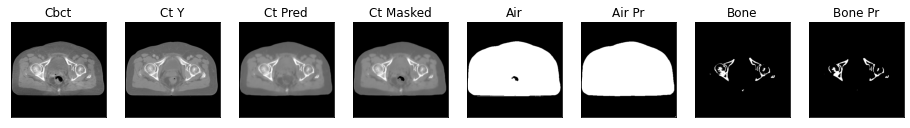

22it [01:14,  2.45s/it]

ssim score = 0.8869400024414062
psnr score = 27.462329864501953
snr score = 18.247467041015625
mae error = 0.015369473025202751
air dice score = 0.9906919928279121
bone dice score = 0.8805704099845401


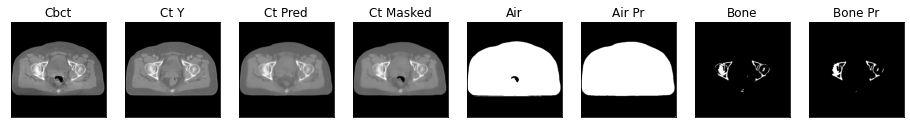

ssim score = 0.8893178105354309
psnr score = 27.25847625732422
snr score = 18.016490936279297
mae error = 0.01592128537595272
air dice score = 0.9917642452930977
bone dice score = 0.9010681141673775


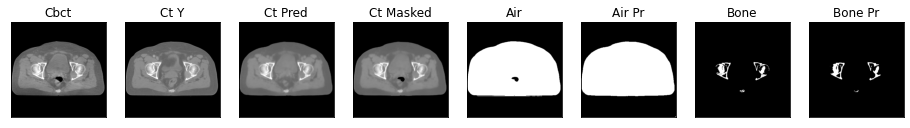

ssim score = 0.8903055191040039
psnr score = 27.125473022460938
snr score = 17.875478744506836
mae error = 0.016349950805306435
air dice score = 0.9926654171234625
bone dice score = 0.9131671407074926


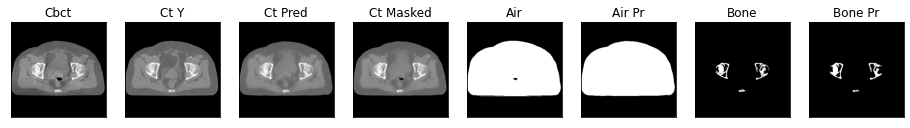

ssim score = 0.8881081938743591
psnr score = 27.15998649597168
snr score = 17.944223403930664
mae error = 0.015527826733887196
air dice score = 0.9929680262751642
bone dice score = 0.9294488188987489


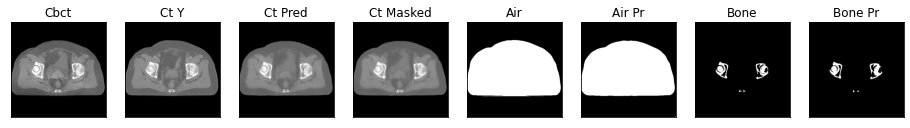

ssim score = 0.8817269802093506
psnr score = 26.45067024230957
snr score = 17.28639793395996
mae error = 0.01659274660050869
air dice score = 0.9932612770820749
bone dice score = 0.9470064092551664


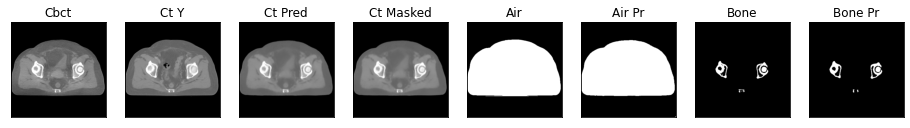

ssim score = 0.8692968487739563
psnr score = 25.31804084777832
snr score = 16.191328048706055
mae error = 0.01863551326096058
air dice score = 0.9930058330799263
bone dice score = 0.944463489887822


ssim score = 0.8572321534156799
psnr score = 24.111291885375977
snr score = 14.912142753601074
mae error = 0.020707378163933754
air dice score = 0.9932620005620758
bone dice score = 0.9334816462751172


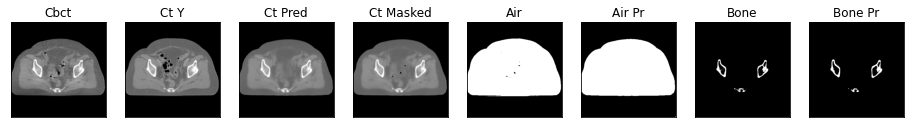

ssim score = 0.8531665205955505
psnr score = 24.128963470458984
snr score = 14.911819458007812
mae error = 0.021358514204621315
air dice score = 0.9927263572590188
bone dice score = 0.9362084456438408


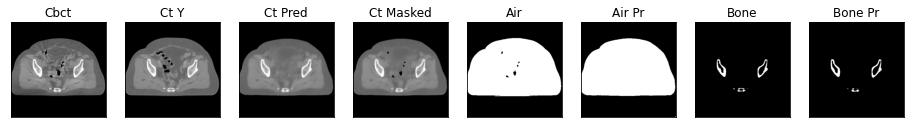

23it [01:16,  2.40s/it]

ssim score = 0.8544065952301025
psnr score = 24.51113510131836
snr score = 15.358905792236328
mae error = 0.020919522270560265
air dice score = 0.9933511623677183
bone dice score = 0.9287238583028441


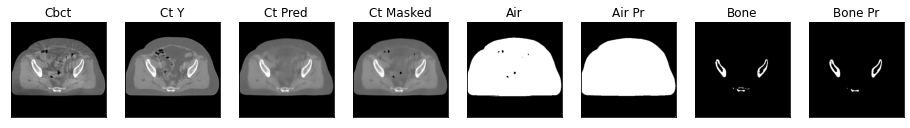

ssim score = 0.8552418351173401
psnr score = 24.213104248046875
snr score = 15.115968704223633
mae error = 0.02155032381415367
air dice score = 0.992591404960891
bone dice score = 0.9398745850250853


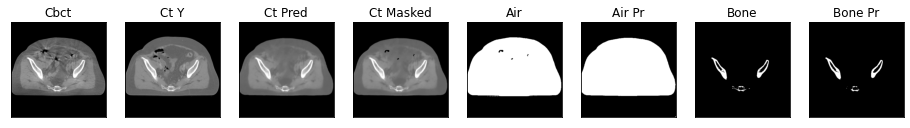

ssim score = 0.8492326140403748
psnr score = 23.814529418945312
snr score = 14.781826972961426
mae error = 0.022736484184861183
air dice score = 0.9933074280267218
bone dice score = 0.9363076923086722


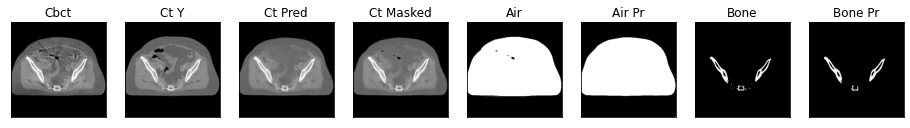

ssim score = 0.8481754064559937
psnr score = 23.8607120513916
snr score = 14.900866508483887
mae error = 0.023228652775287628
air dice score = 0.9926791635205721
bone dice score = 0.8986019131729418


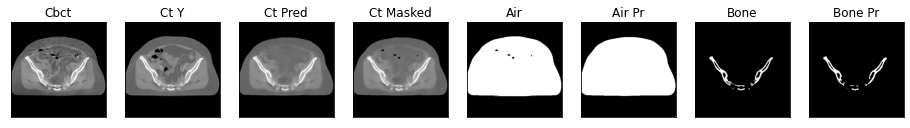

ssim score = 0.8447291851043701
psnr score = 23.841039657592773
snr score = 14.876904487609863
mae error = 0.023497188463807106
air dice score = 0.991621494839993
bone dice score = 0.9064916119634355


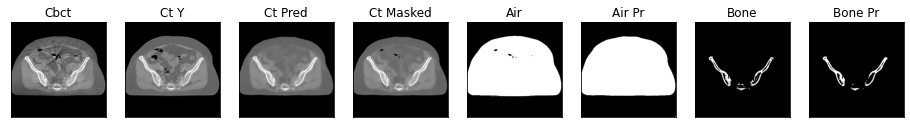

ssim score = 0.8404487371444702
psnr score = 23.465965270996094
snr score = 14.47965145111084
mae error = 0.024440350010991096
air dice score = 0.9920192313905976
bone dice score = 0.9037703995511569


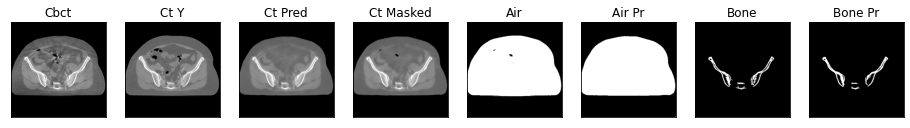

ssim score = 0.8414784073829651
psnr score = 23.72777557373047
snr score = 14.753095626831055
mae error = 0.024008670821785927
air dice score = 0.9919780262093979
bone dice score = 0.910423691542143


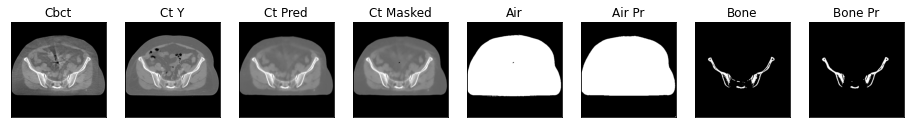

24it [01:18,  3.27s/it]


In [46]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [36]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [37]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [38]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.25it/s]


(0.8591879978775978,
 24.40472475687663,
 15.419295152028402,
 0.02276861477488031,
 0.9927778278032805,
 0.9155694575452181,
 0.4947916666666667)

In [47]:
# masked
eval_epoch(model, discriminator, testloader, device)

0it [00:00, ?it/s]


NameError: name 'air_masked' is not defined

In [39]:
# import torchvision.models as models
# models.vgg16(pretrained=True)